# **Walmart Recruiting - Store Sales Forecasting**

We are provided historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments, and we are tasked with predicting the department-wide sales for each store.

In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data.

# Overview
The dataset essentially contains five scv files which are descibed as follows.

**stores.csv:**

  This file contains anonymized information about the 45 stores, indicating      the type and size of store.

**train.csv:**

  This is the historical training data, which covers to 2010-02-05 to 2012-11-01. Within this file we will find the following fields:

  - Store - the store number
  - Dept - the department number
  - Date - the week
  - Weekly_Sales -  sales for the given department in the given store
  - IsHoliday - whether the week is a special holiday week

**test.csv:**

 This file is identical to train.csv, except we have withheld the weekly sales. We must predict the sales for each triplet of store, department, and date in this file.

**features.csv:**

 This file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:

  - Store - the store number
  - Date - the week
  - Temperature - average temperature in the region
  - Fuel_Price - cost of fuel in the region
  - MarkDown1 to MarkDown5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
  - CPI - the consumer price index
  - Unemployment - the unemployment rate
  - IsHoliday - whether the week is a special holiday week

**sampleSubmission.csv:**

We have been provided with dates where we can predict the salesfor each date mentioned in this csv file.

For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):

  - Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
  -Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
  - Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
  - Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

**Evaluation:**

 This competition is evaluated on the weighted mean absolute error (WMAE):
 >$WMAE = [1/(sum_{i=1}^n w_i]) \sum_{i=1}^n \ w_i|y_i - y_i^{hat}|$

 where
 * n is the number of rows
 * $y_i^{hat}$  is the predicted sales
 * $y_i$  is the actual sales
 * $w_i$  are weights, w = 5 if the week is a holiday week, 1 otherwise


## Import libraries

In [1]:
# importing all the libraries needed 
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
sns.set_style("whitegrid")
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error

#For date time functions
from datetime import datetime
from datetime import timedelta
import math

# Importing the most popular regression libraries.
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, ridge_regression, Lasso, SGDRegressor, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
# auto-arima library comes under pyramid utility function, hence installing pyramid library.
!pip install pmdarima
import pmdarima

     |████████████████████████████████| 1.5MB 8.6MB/s 
     |████████████████████████████████| 9.5MB 21.9MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
# from google.colab import files
# uploaded = files.upload()

In [4]:
# !apt install unzip
# !unzip  walmart-recruiting-store-sales-forecasting.zip

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Dataset

In [6]:
data_dir = '/content/drive/MyDrive/HUST/20202/Phân tích nghiệp vụ thông minh/Data/'

In [7]:
#Loading the data from csv files.
train = pd.read_csv(data_dir + 'train.csv')
features = pd.read_csv(data_dir + 'features.csv')
stores = pd.read_csv(data_dir + 'stores.csv')

In [133]:
train

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Date_dayofweek,Date_month,Date_year,Date_day
0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,1,151315,4,2,2010,5
1,1,2,2010-02-05,50605.27,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,1,151315,4,2,2010,5
2,1,3,2010-02-05,13740.12,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,1,151315,4,2,2010,5
3,1,4,2010-02-05,39954.04,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,1,151315,4,2,2010,5
4,1,5,2010-02-05,32229.38,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,1,151315,4,2,2010,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,2487.80,0,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221,4,10,2012,26
421566,45,94,2012-10-26,5203.31,0,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221,4,10,2012,26
421567,45,95,2012-10-26,56017.47,0,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221,4,10,2012,26
421568,45,97,2012-10-26,6817.48,0,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221,4,10,2012,26


In [132]:
features

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False


In [135]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


# Data Cleanning

## Check data

In [11]:
#Check for null values in train
train.isnull().any()

Store           False
Dept            False
Date            False
Weekly_Sales    False
IsHoliday       False
dtype: bool

In [12]:
#Check for null values in features.
features.isnull().any()

Store           False
Date            False
Temperature     False
Fuel_Price      False
MarkDown1        True
MarkDown2        True
MarkDown3        True
MarkDown4        True
MarkDown5        True
CPI              True
Unemployment     True
IsHoliday       False
dtype: bool

In [13]:
#Check for null values in stores.
stores.isnull().any()

Store    False
Type     False
Size     False
dtype: bool

There are null values present in below columns.
- MarkDown1, MarkDown2, MarkDown3, MarkDown4, MarkDown5, CPI and Unemployment


In [14]:
#Count of null values present in respective columns of features.
features.isnull().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

In [15]:
#Original shape of train, features and stores data.
print('train: ', train.shape)
print('features: ', features.shape)
print('stores ', stores.shape)

train:  (421570, 5)
features:  (8190, 12)
stores  (45, 3)


## Merge data

In [16]:
#Merging the three csv files using inner join.
data = train.merge(features, on=['Store', 'Date'], how='inner').merge(stores, on=['Store'], how='inner')
print(data.shape)

(421570, 17)


In [17]:
data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315


In [18]:
# Removing additional IsHoliday column (IsHoliday_y) and renaming original IsHoliday_x column to IsHoliday.
data = data.drop(['IsHoliday_y'], axis=1)
data = data.rename(columns={'IsHoliday_x':'IsHoliday'})
data.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size'],
      dtype='object')

In [19]:
data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


In [20]:
data.shape

(421570, 16)

## Dense

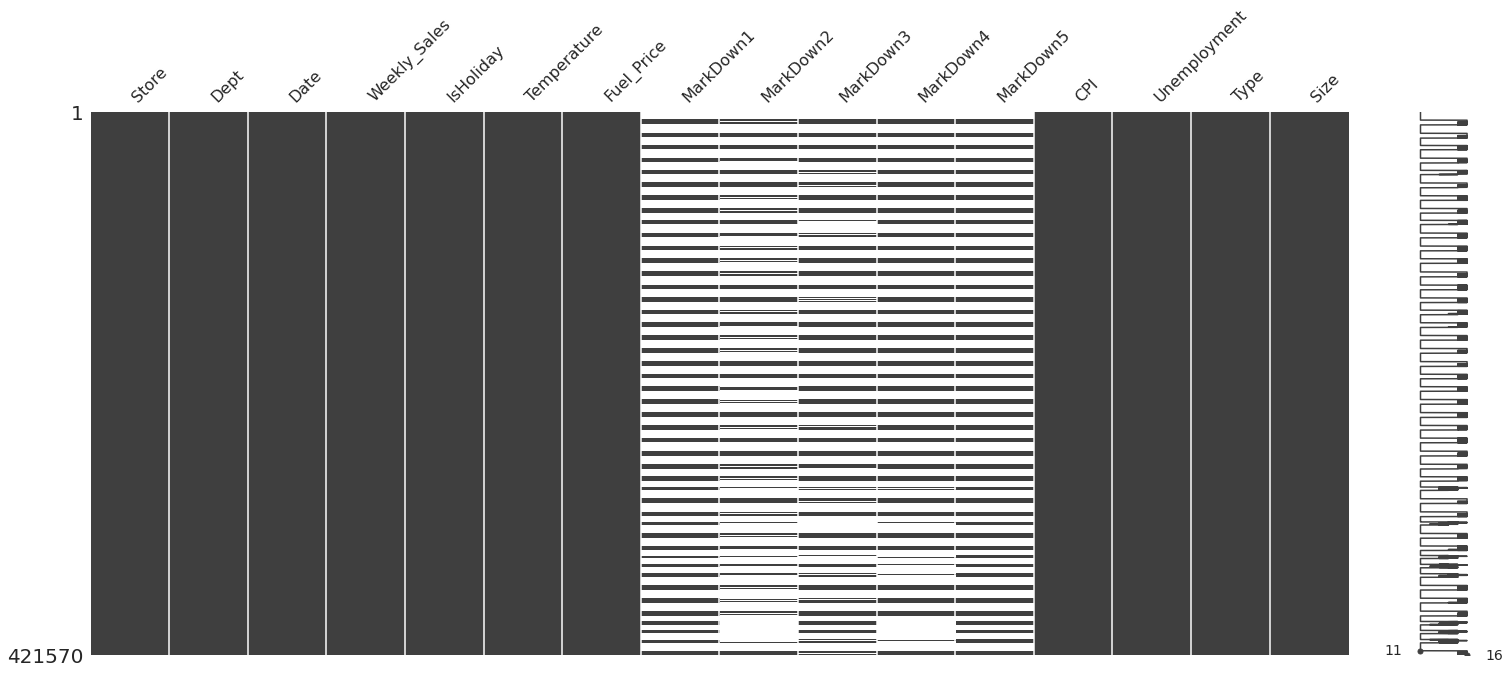

In [21]:
import missingno as msno
msno.matrix(data)

## Handle missing values

NaN for markdown means that there was no markdown event for that date. So we can replace that with 0 indicating no mark down

In [22]:
# First we check what happens when we replace NaN's with 0.
data.fillna(0).head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315


There are null values present in the dataset. Let's remove those.

In [23]:
data.isnull().head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,False,False,False,False,False,False,False,True,True,True,True,True,False,False,False,False
1,False,False,False,False,False,False,False,True,True,True,True,True,False,False,False,False
2,False,False,False,False,False,False,False,True,True,True,True,True,False,False,False,False
3,False,False,False,False,False,False,False,True,True,True,True,True,False,False,False,False
4,False,False,False,False,False,False,False,True,True,True,True,True,False,False,False,False


In [24]:
data.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
dtype: int64

In [25]:
# Removing rows with null values in all columns
data.dropna(axis=0, how="all", inplace=True)
# Removing all rows with null values in all rows
data.dropna(axis=1, how="all", inplace=True)

In [26]:
data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


In [27]:
# Fill missing values with 0
data = data.fillna(0)

In [28]:
data.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
dtype: int64

In [29]:
data.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,60.090059,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289,136727.915739
std,12.785297,30.492054,22711.183519,18.447931,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296,60980.583328
min,1.000000,1.000000,-4988.940000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2079.650000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7612.030000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000,140167.000000
75%,33.000000,74.000000,20205.852500,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


In [30]:
print('Final Data Shape: ', data.shape)

Final Data Shape:  (421570, 16)


In [31]:
# # Taking Mean of Temparature, Weekly Sales and Unemployment columns and forming additional columns.
# temp_mean = data.Temperature.fillna(data['Temperature'].mean())
# unemployment_mean = data.Unemployment.fillna(data['Unemployment'].mean())
# weekly_sales_mean = data.Weekly_Sales.fillna(data['Weekly_Sales'].mean())

# data['Weekly Sales Mean'] = weekly_sales_mean
# data['Unemployment Mean'] = unemployment_mean
# data['Temperature Mean']  = temp_mean

In [32]:
data.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Weekly Sales Mean,Unemployment Mean,Temperature Mean
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,60.090059,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289,136727.915739,15981.258123,7.960289,60.090059
std,12.785297,30.492054,22711.183519,18.447931,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296,60980.583328,22711.183519,1.863296,18.447931
min,1.000000,1.000000,-4988.940000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000,-4988.940000,3.879000,-2.060000
25%,11.000000,18.000000,2079.650000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000,2079.650000,6.891000,46.680000
50%,22.000000,37.000000,7612.030000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000,140167.000000,7612.030000,7.866000,62.090000
75%,33.000000,74.000000,20205.852500,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000,202505.000000,20205.852500,8.572000,74.280000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000,693099.360000,14.313000,100.140000


In [33]:
data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Weekly Sales Mean,Unemployment Mean,Temperature Mean
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,24924.50,8.106,42.31
1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,50605.27,8.106,42.31
2,1,3,2010-02-05,13740.12,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,13740.12,8.106,42.31
3,1,4,2010-02-05,39954.04,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,39954.04,8.106,42.31
4,1,5,2010-02-05,32229.38,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,32229.38,8.106,42.31


In [34]:
# Remove negative values as sales cannot be negative values.
data = data[data['Weekly_Sales'] >= 0]
data.shape

(420285, 19)

# Exploratory Data Analysis



## 1.Weekly Sales by Department

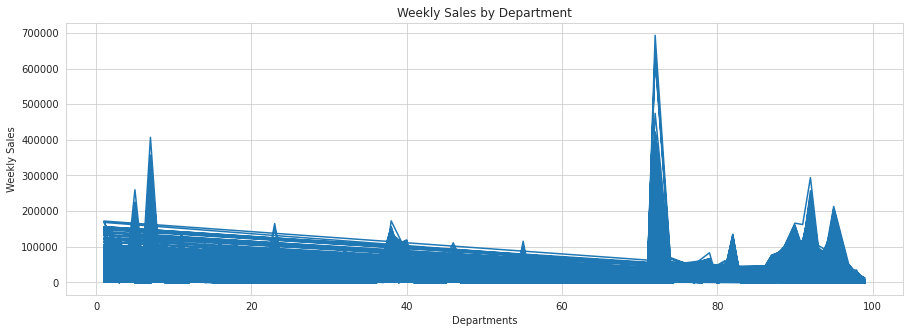

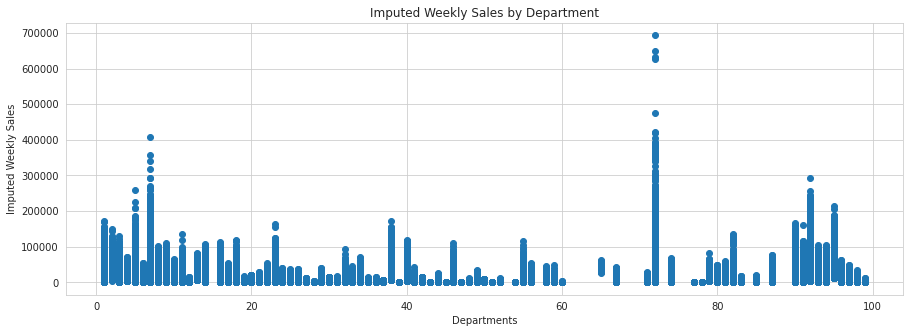

In [35]:
#Plot of Weekly Sales and Department.
x = data['Dept']
y = data['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Department')
plt.xlabel('Departments')
plt.ylabel('Weekly Sales')
plt.plot(x,y)
plt.show()

#Plot of Mean Weekly Sales and Department.
x = data['Dept']
y = data['Weekly Sales Mean']
plt.figure(figsize=(15,5))
plt.title('Imputed Weekly Sales by Department')
plt.xlabel('Departments')
plt.ylabel('Imputed Weekly Sales')
plt.scatter(x,y)
plt.show()

 - Observation: Most of the Departments have weekly sales below 200000.

## 2.Weekly Sales by Stores

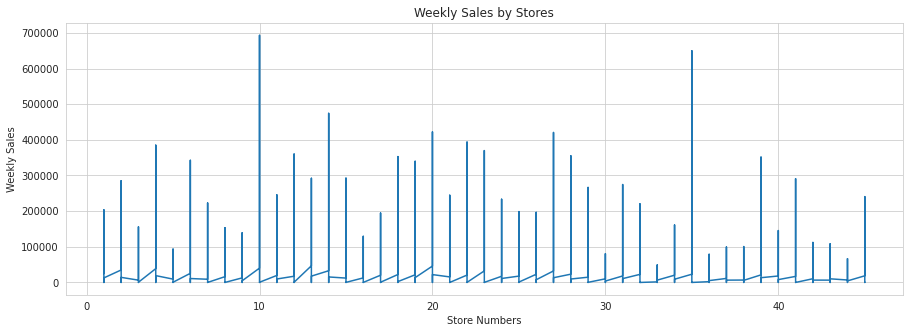

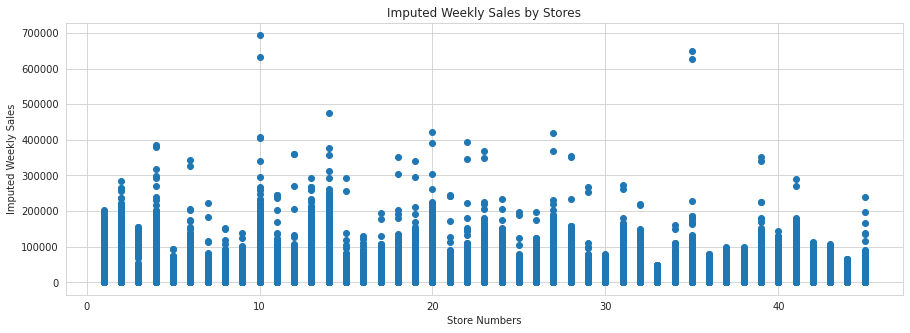

In [36]:
#Plot of Weekly Sales and Stores.
x = data['Store']
y = data['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Stores')
plt.xlabel('Store Numbers')
plt.ylabel('Weekly Sales')
plt.plot(x,y)
plt.show()

#Plot of Mean Weekly Sales and Stores.
x = data['Store']
y = data['Weekly Sales Mean']
plt.figure(figsize=(15,5))
plt.title('Imputed Weekly Sales by Stores')
plt.xlabel('Store Numbers')
plt.ylabel('Imputed Weekly Sales')
plt.scatter(x,y)
plt.show()

 - Observation: Weekly sales is highest for Store number 10 and lowest for Store number 33.

## 3.Weekly Sales by Year, Month and Week

In [37]:
# First we need to get Year, Month and Week columns from Date column.
data.Date = pd.to_datetime(data.Date)
data['Year']  = data.Date.dt.year
data['Month'] = data.Date.dt.month
data['Week']  = data.Date.dt.week

data.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Weekly Sales Mean,Unemployment Mean,Temperature Mean,Year,Month,Week
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,24924.50,8.106,42.31,2010,2,5
1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,50605.27,8.106,42.31,2010,2,5


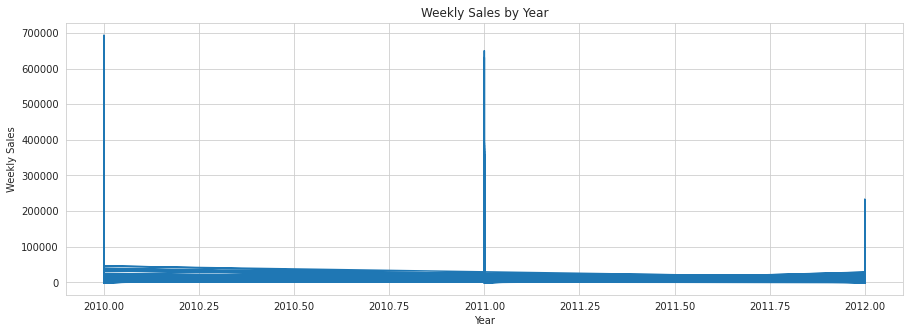

In [38]:
# Plot of Weekly Sales and Year.
x = data['Year']
y = data['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Year')
plt.xlabel('Year')
plt.ylabel('Weekly Sales')
plt.plot(x,y)
plt.show()

In [39]:
data['Year'][100000:110000]

100216    2010
100217    2010
100218    2010
100219    2010
100220    2010
          ... 
110239    2010
110240    2010
110241    2010
110242    2010
110243    2010
Name: Year, Length: 10000, dtype: int64

 - Observation: Year 2011 had the highest weekly sales.

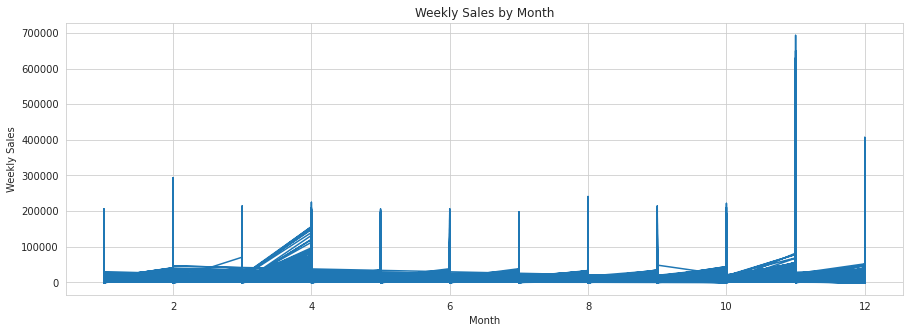

In [40]:
# Plot of Weekly Sales and Month.
x = data['Month']
y = data['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Month')
plt.xlabel('Month')
plt.ylabel('Weekly Sales')
plt.plot(x,y)
plt.show()

 - Observation: November month witnessed the maximum weekly sales.

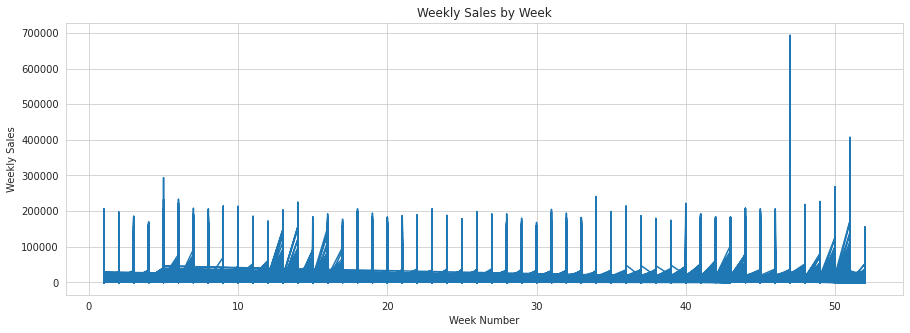

In [41]:
# Plot of Weekly Sales and Week.
x = data['Week']
y = data['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Week')
plt.xlabel('Week Number')
plt.ylabel('Weekly Sales')
plt.plot(x,y)
plt.show()

 - Observation: Week 47 of November month had the highest weekly sales.

## 4.Store Size by Store Type

- Let's make a pie chart to show the ratio of A, B, and C types of total 45 Walmart stores.
- First, let's group data by type of stores and see the descriptive figures.
- Later we will plot box plot for Store Type and Store Size.

In [42]:
print("the shape of stores data set is", stores.shape)
print('='*50)
print("the unique value of store is", stores['Store'].unique())
print('='*110)
print("the unique value of Type is", stores['Type'].unique())

the shape of stores data set is (45, 3)
the unique value of store is [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
the unique value of Type is ['A' 'B' 'C']


In [43]:
sorted_type = stores.groupby('Type')
print(sorted_type.describe()['Size'].round(2))

      count       mean       std  ...       50%       75%       max
Type                              ...                              
A      22.0  177247.73  49392.62  ...  202406.0  203819.0  219622.0
B      17.0  101190.71  32371.14  ...  114533.0  123737.0  140167.0
C       6.0   40541.67   1304.15  ...   39910.0   40774.0   42988.0

[3 rows x 8 columns]


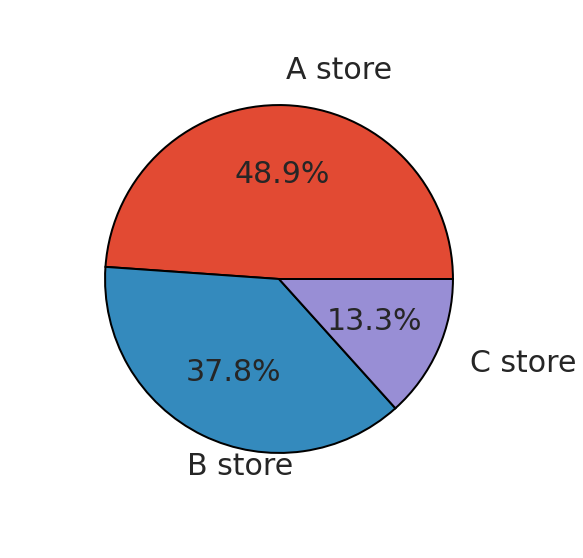

In [44]:
# Make Pie chart for Stores including Weekly Sales.
plt.style.use('ggplot')
labels=['A store','B store','C store']
sizes=sorted_type.describe()['Size'].round(1)
sizes=[(22/(17+6+22))*100,(17/(17+6+22))*100,(6/(17+6+22))*100] # convert to the proportion

fig, axes = plt.subplots(1,1, figsize=(10,10))

wprops={'edgecolor':'black',
      'linewidth':2}

tprops = {'fontsize':30}

axes.pie(sizes,
        labels=labels,
        explode=(0.0,0,0),
        autopct='%1.1f%%',
        pctdistance=0.6,
        labeldistance=1.2,
        wedgeprops=wprops,
        textprops=tprops,
        radius=0.8,
        center=(0.5,0.5))
plt.show()

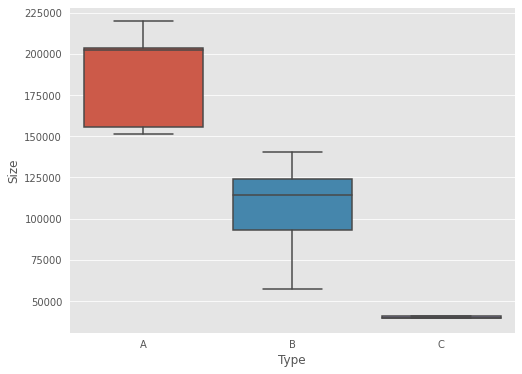

In [45]:
# Box Plot of Store Type and Store Size.
type_size = pd.concat([stores['Type'], stores['Size']], axis=1)
plt.figure(figsize=(8,6))
fig = sns.boxplot(x='Type', y='Size', data=type_size, showfliers=False)

Observations:
- Type A store is the largest store and C being the smallest.
- There is considerable separation among the store types, hence store type is best predictor for store size.


## 5.Train-Stores table analysis

In [46]:
train_stores = train.merge(stores, on='Store', how='inner')
train_stores.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size
0,1,1,2010-02-05,24924.50,False,A,151315
1,1,1,2010-02-12,46039.49,True,A,151315
2,1,1,2010-02-19,41595.55,False,A,151315
3,1,1,2010-02-26,19403.54,False,A,151315
4,1,1,2010-03-05,21827.90,False,A,151315


In [47]:
# Form Date, Year, Month, Week, Day and No. of days.
train_stores['Date'] = pd.to_datetime(train_stores['Date'])
train_stores['Year'] = train_stores['Date'].dt.year
train_stores['Month']= train_stores['Date'].dt.month
train_stores['Week'] = train_stores['Date'].dt.week
train_stores['Day']  = train_stores['Date'].dt.day
train_stores['No. of days'] = (train_stores['Date'].dt.date - train_stores['Date'].dt.date.min()).apply(lambda x:x.days)

In [48]:
train_stores.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Year,Month,Week,Day,No. of days
0,1,1,2010-02-05,24924.50,False,A,151315,2010,2,5,5,0
1,1,1,2010-02-12,46039.49,True,A,151315,2010,2,6,12,7
2,1,1,2010-02-19,41595.55,False,A,151315,2010,2,7,19,14
3,1,1,2010-02-26,19403.54,False,A,151315,2010,2,8,26,21
4,1,1,2010-03-05,21827.90,False,A,151315,2010,3,9,5,28


In [49]:
Year        = pd.Series(train_stores['Year'].unique())
Week        = pd.Series(train_stores['Week'].unique())
Month       = pd.Series(train_stores['Month'].unique())
Day         = pd.Series(train_stores['Day'].unique())
No_of_days  = pd.Series(train_stores['No. of days'].unique())

## 6.Weekly Sales for Store Type

In [50]:
# There are negative values present in Weekly sales which are absurd because sales cannot be negative.
train_stores= train_stores[train_stores['Weekly_Sales'] > 0]

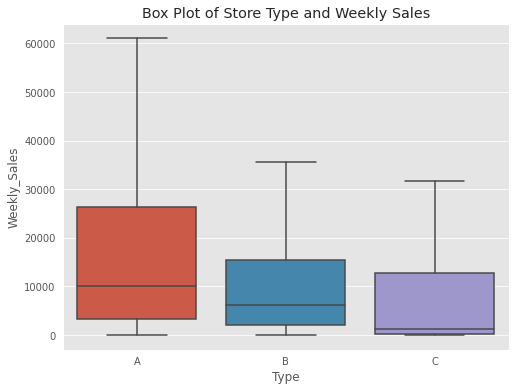

In [51]:
# Plot of Store Type and Weekly Sales
type_sales = pd.concat([train_stores['Type'], train_stores['Weekly_Sales']], axis=1)
plt.figure(figsize=(8,6))
plt.title('Box Plot of Store Type and Weekly Sales')
fig = sns.boxplot(x='Type', y='Weekly_Sales', data=type_sales, showfliers=False)

 - Observation: Type A stores have their medians higher than any other medians in other store types, so the weekly sales for store type A is more than other store types.

## 7.Weekly Sales for Store Size

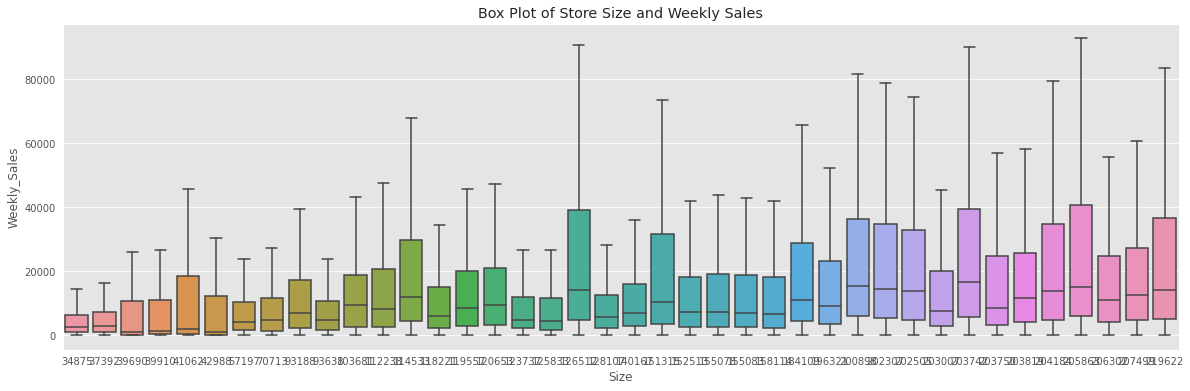

In [52]:
# Plot of Store Size and Weekly Sales.
size_sales = pd.concat([train_stores['Size'], train_stores['Weekly_Sales']], axis=1)
plt.figure(figsize=(20,6))
plt.title('Box Plot of Store Size and Weekly Sales')
fig = sns.boxplot(x='Size', y='Weekly_Sales', data=size_sales, showfliers=False)

 - Observation: There is no clear distinction that can be drawn from this plot.

## 8.Weekly Sales by Store Number and Store Type

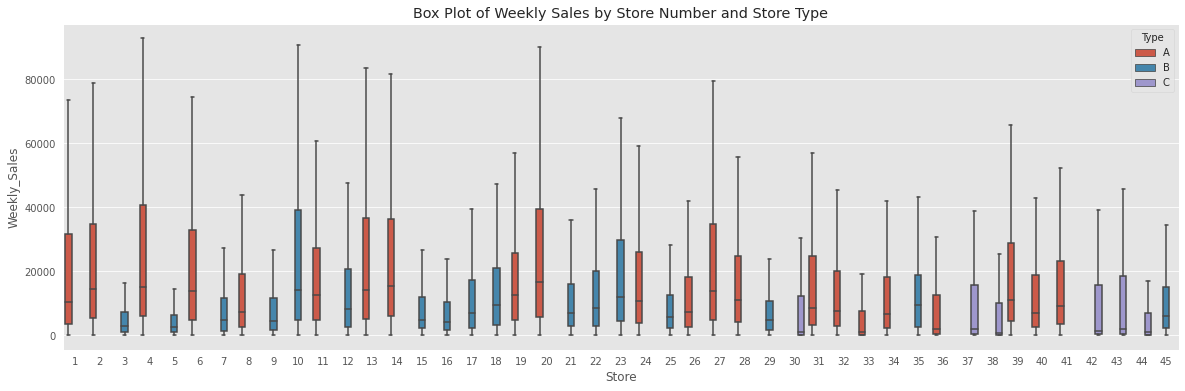

In [53]:
# Plot of Weekly Sales by Store Number and Store Type.
data_8 = pd.concat([train_stores['Store'], train_stores['Weekly_Sales'], train_stores['Type']], axis=1)
plt.figure(figsize=(20,6))
plt.title('Box Plot of Weekly Sales by Store Number and Store Type')
fig = sns.boxplot(x='Store', y='Weekly_Sales', data=data_8, showfliers=False, hue='Type')

 - Observation: We can observe that store number 4 followed by 20 have the highest sales, so are their median sales values.

## 9.Weekly Sales by Store Number and Holiday

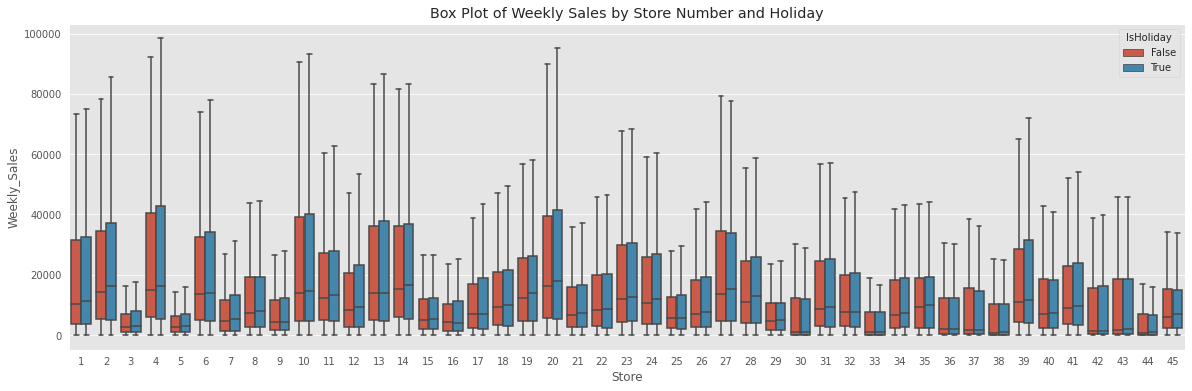

In [54]:
# Plot of Weekly Sales by Store Number and Holiday.
data_9 = pd.concat([train_stores['Store'], train_stores['Weekly_Sales'], train_stores['IsHoliday']], axis=1)
plt.figure(figsize=(20,6))
plt.title('Box Plot of Weekly Sales by Store Number and Holiday')
fig = sns.boxplot(x='Store', y='Weekly_Sales', data=data_9, showfliers=False, hue='IsHoliday')

 - Observation: We can't interpret the reation here, but we can observe that sales are more on holidays.

## 10.Weekly Sales by Department and Store Type

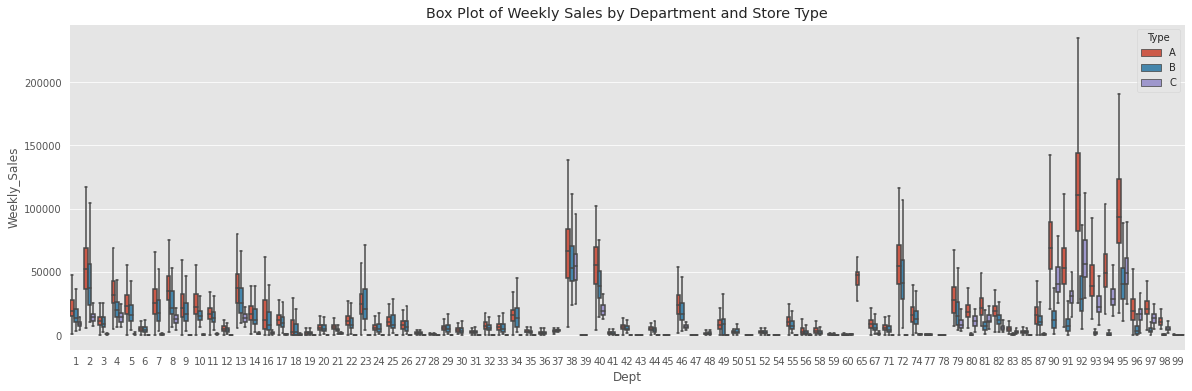

In [55]:
data_10 = pd.concat([train_stores['Dept'], train_stores['Weekly_Sales'], train_stores['Type']], axis=1)
plt.figure(figsize=(20,6))
plt.title('Box Plot of Weekly Sales by Department and Store Type')
fig = sns.boxplot(x='Dept', y='Weekly_Sales', data=data_10, showfliers=False, hue='Type')

 - Observation: Here we can infer that weekly sales for store type A is more than any other store types.

## 11.Weekly Sales by Department and Holiday

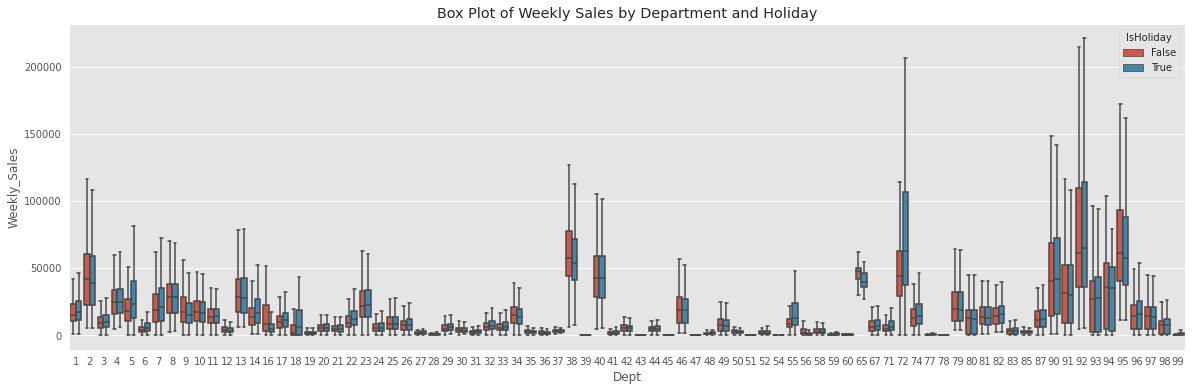

In [56]:
data_11= pd.concat([train_stores['Dept'], train_stores['Weekly_Sales'], train_stores['IsHoliday']], axis=1)
plt.figure(figsize=(20,6))
plt.title('Box Plot of Weekly Sales by Department and Holiday')
fig = sns.boxplot(x='Dept', y='Weekly_Sales', data=data_11, showfliers=False, hue="IsHoliday")

Observations:
- Department number 92 has highest sales that too happened on holiday.
- There is no explicit relation between Department and Weekly Sales.

## 12.Weekly Sales on Holidays and Non-Holidays

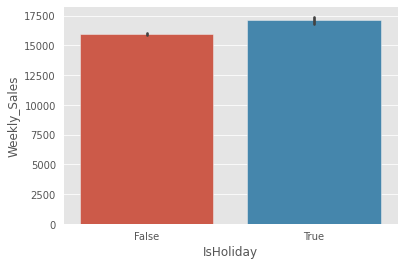

In [57]:
holiday = train_stores['Weekly_Sales'].loc[train_stores['IsHoliday']== True] # Weekly Sales in Holidays
non_holiday = train_stores['Weekly_Sales'].loc[train_stores['IsHoliday']== False] #Weekly Sales in Non-holidays.

sns.barplot(x='IsHoliday', y='Weekly_Sales', data=train_stores)

 - Observation: We see the sales are higher on holidays than on non holidays.

## 13.Monthwise Weekly Sales

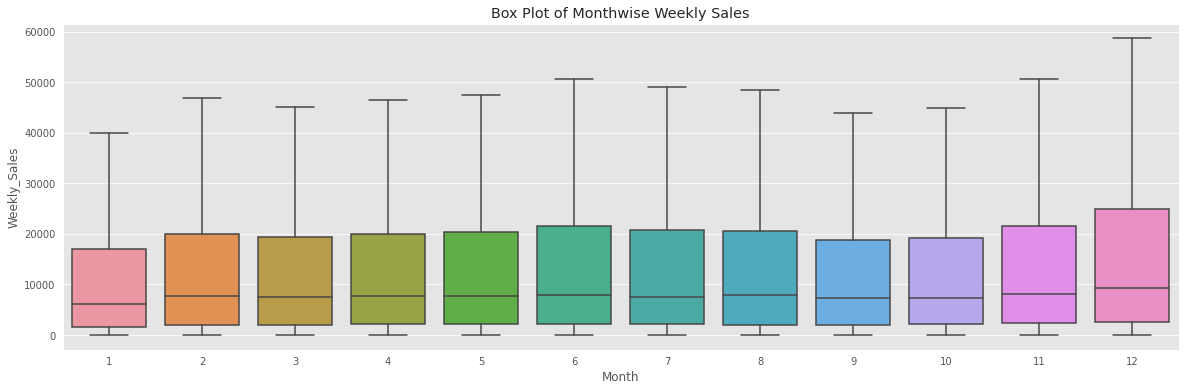

In [58]:
data_13 = pd.concat([train_stores['Month'], train_stores['Weekly_Sales']], axis=1)
plt.figure(figsize=(20,6))
plt.title('Box Plot of Monthwise Weekly Sales')
fig = sns.boxplot(x='Month', y='Weekly_Sales', data=data_13, showfliers=False)

 - Observation: December month had maximum sales.

## 14.Weekly Sales by Month and Holiday

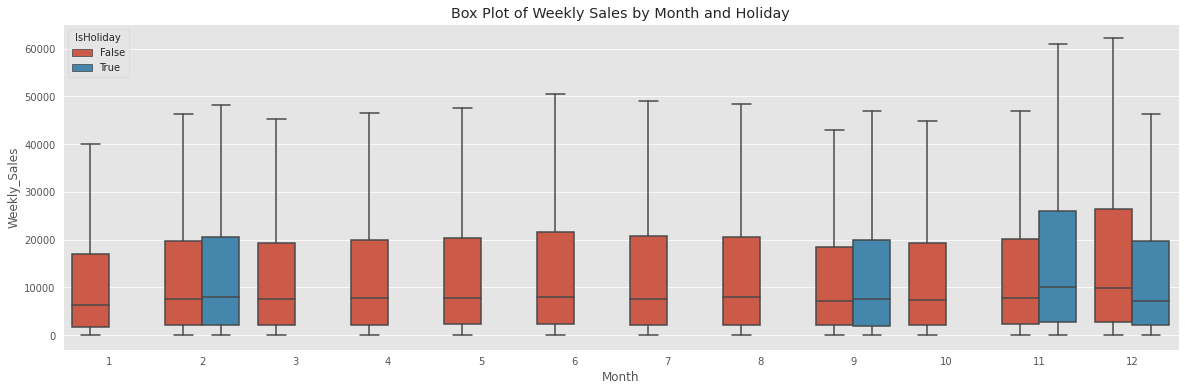

In [59]:
data_14 = pd.concat([train_stores['Month'], train_stores['Weekly_Sales'], train_stores['IsHoliday']], axis=1)
plt.figure(figsize=(20,6))
plt.title('Box Plot of Weekly Sales by Month and Holiday')
fig = sns.boxplot(x='Month', y='Weekly_Sales', data=data_14, showfliers=False, hue='IsHoliday')

 - Observation: Non holidays have sales in each of the monhs and in December the sales, which is the highest among all sales, is even more than sales in holidays.

## 15.Weekly Sales by Month and Store Type

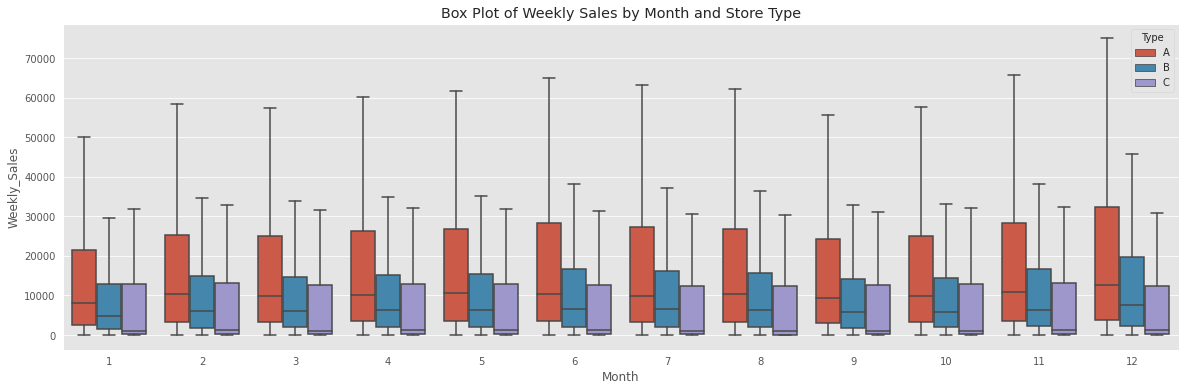

In [60]:
data_15 = pd.concat([train_stores['Month'], train_stores['Weekly_Sales'], train_stores['Type']], axis=1)
plt.figure(figsize=(20,6))
plt.title('Box Plot of Weekly Sales by Month and Store Type')
fig = sns.boxplot(x='Month', y='Weekly_Sales', data=data_15, showfliers=False, hue='Type')

 - Observation: In every month Store Type A has the maximum sales.

## 16.Weekly Sales by Year

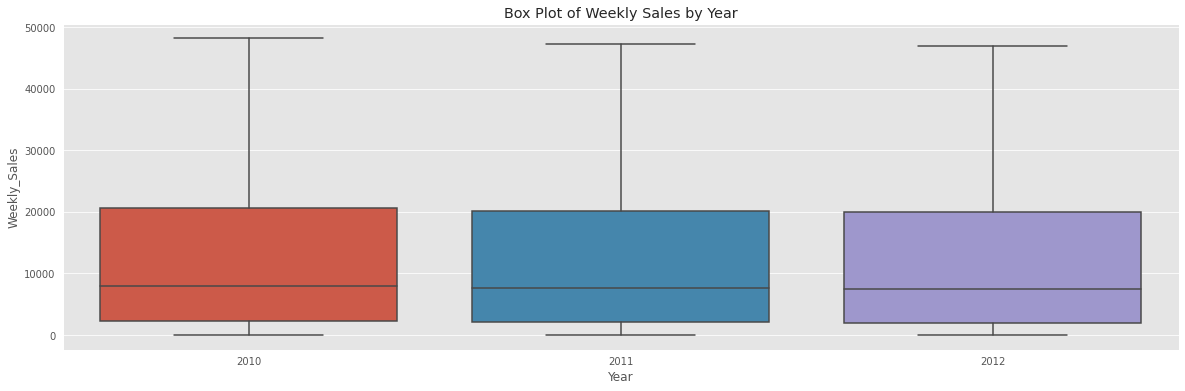

In [61]:
data_16 = pd.concat([train_stores['Year'], train_stores['Weekly_Sales']], axis=1)
plt.figure(figsize=(20,6))
plt.title('Box Plot of Weekly Sales by Year')
fig = sns.boxplot(x='Year', y='Weekly_Sales', data=data_16, showfliers=False)

 - Observation: There seems no clear distinction from this plot.

## 17.Weekly Sales by Week

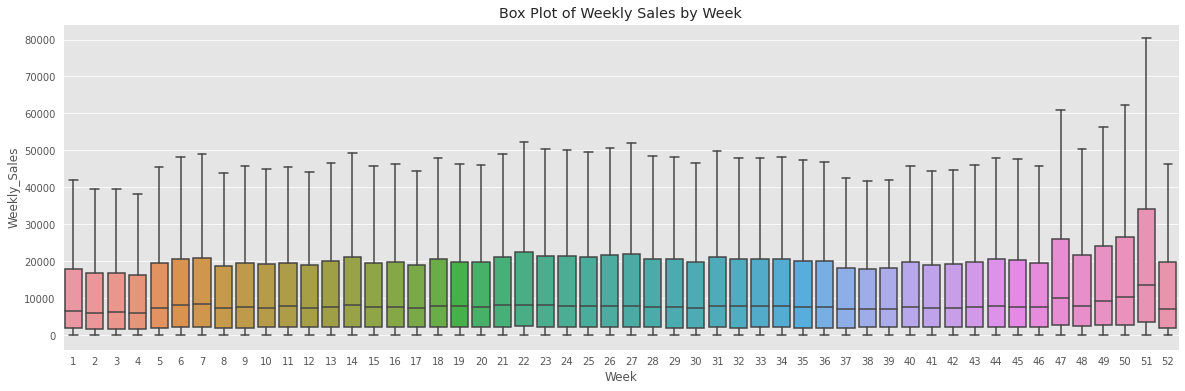

In [62]:
data_17 = pd.concat([train_stores['Week'], train_stores['Weekly_Sales']], axis=1)
plt.figure(figsize=(20,6))
plt.title('Box Plot of Weekly Sales by Week')
fig = sns.boxplot(x='Week', y='Weekly_Sales', data=data_17, showfliers=False)

 - Observation: The 51st week i.e. third week of December has the highest sales.

## 18.Histogram of Weekly Sales

Minimum sales: 0.01


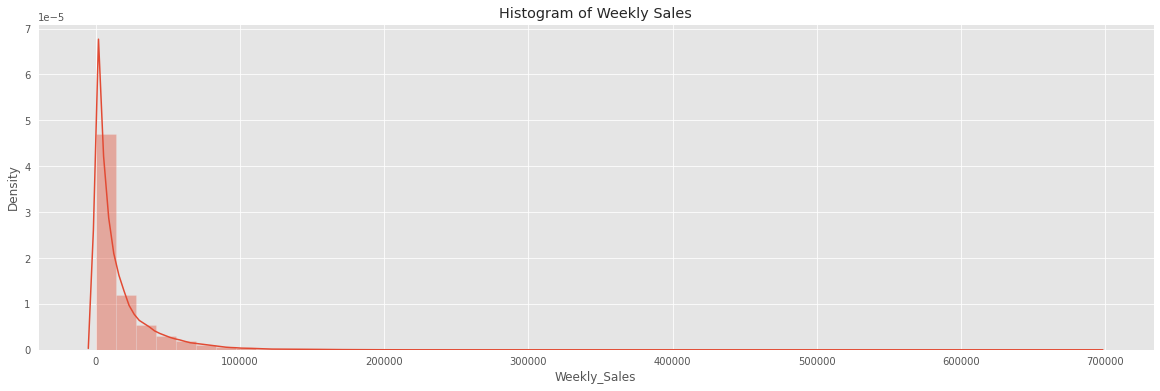

In [63]:
plt.figure(figsize=(20,6))
plt.title('Histogram of Weekly Sales')
fig = sns.distplot(train_stores['Weekly_Sales'].dropna()) #Taking only valid weekly sales values.
print('Minimum sales:', train_stores['Weekly_Sales'].min())

 - Observation: About all sales have happened below 100000. Maximum sales are done at sales value of 1000.

## 19.Probability Plot of Weekly Sales

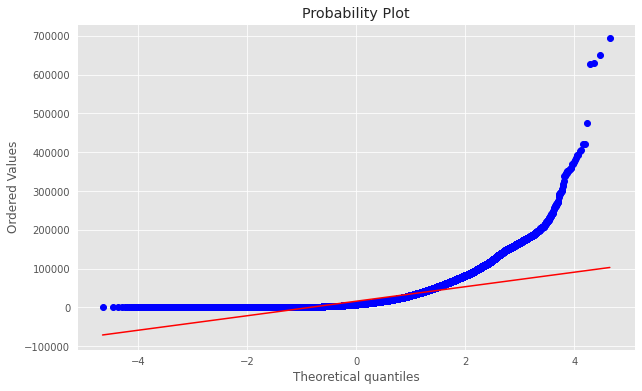

In [64]:
plt.figure(figsize=(10,6))
fig = stats.probplot(train_stores['Weekly_Sales'], plot=plt)

## 20.Distributions of 5 MarkDowns

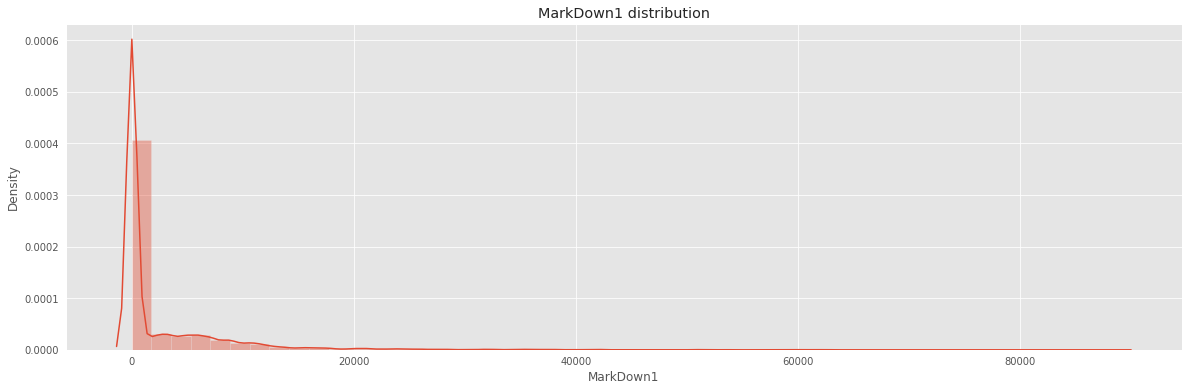

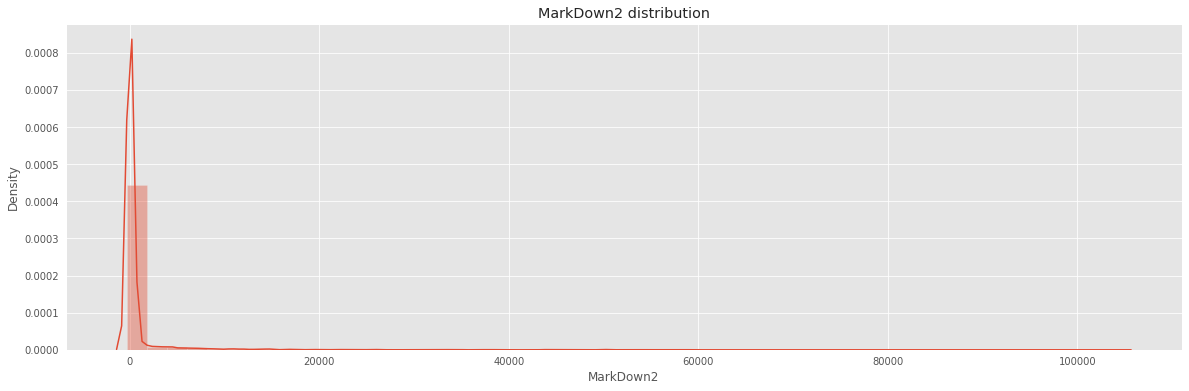

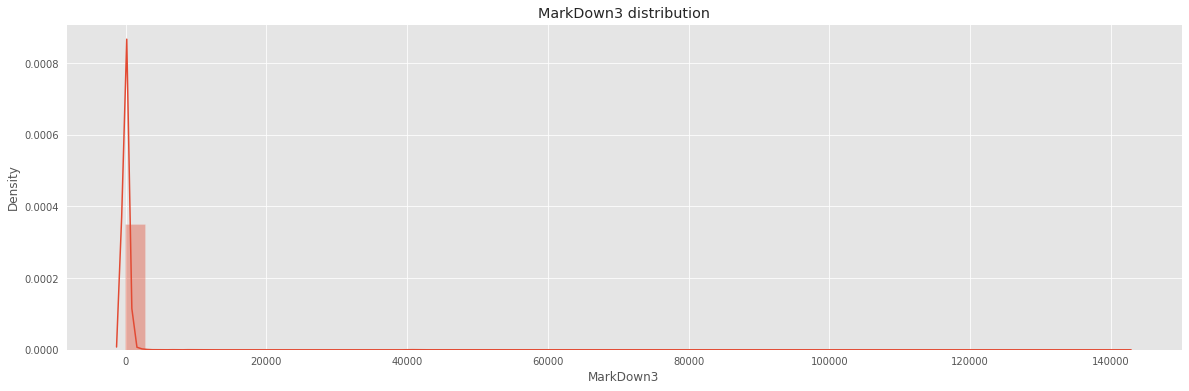

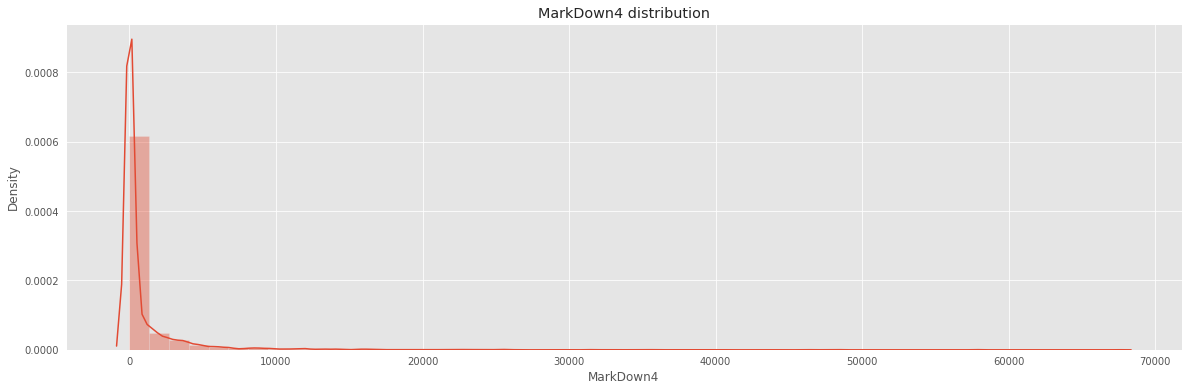

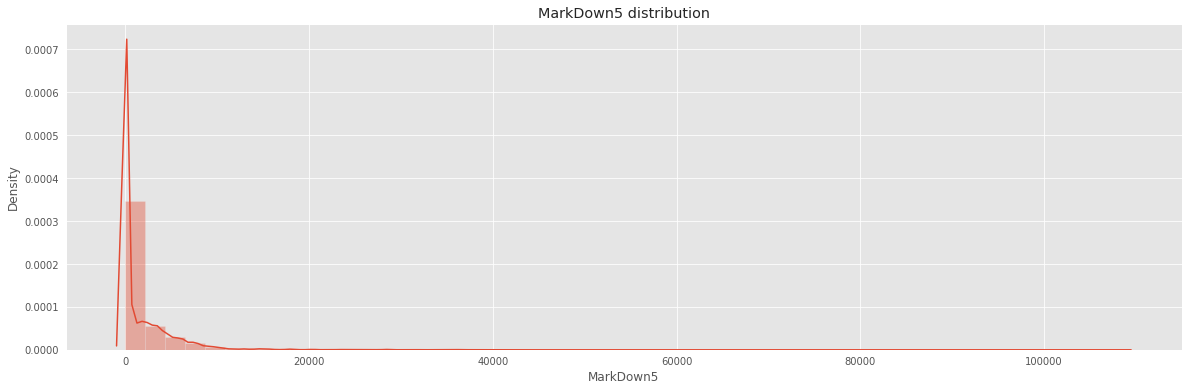

In [65]:
# Histograms of MarkDowns.
def markdowns(data, column):
  plt.figure(figsize=(20,6))
  sns.distplot(data[column], kde=True)
  plt.title(str(column)+' distribution')
  plt.xlabel(column)
  
markdowns(data, 'MarkDown1')
markdowns(data, 'MarkDown2')
markdowns(data, 'MarkDown3')
markdowns(data, 'MarkDown4')
markdowns(data, 'MarkDown5')

In [66]:
# Scatter plots of MarkDowns.
def scatter(data, column):
    plt.figure(figsize=(20,6))
    plt.scatter(data[column] , data['Weekly_Sales'])
    plt.title('Weekly sales by '+str(column))
    plt.ylabel('Weekly_Sales')
    plt.xlabel(column)
    

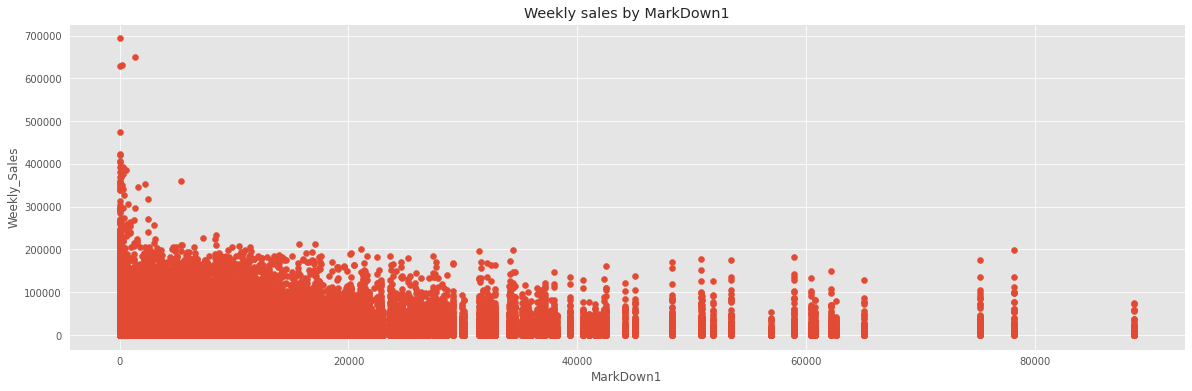

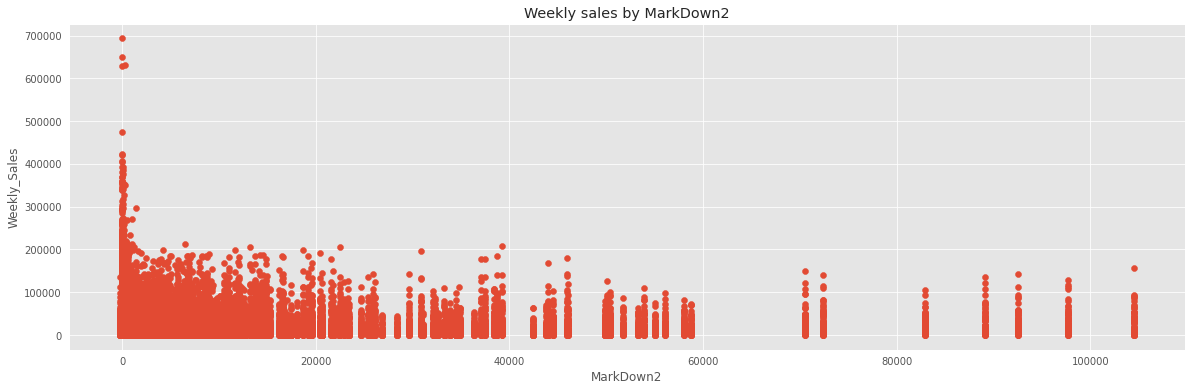

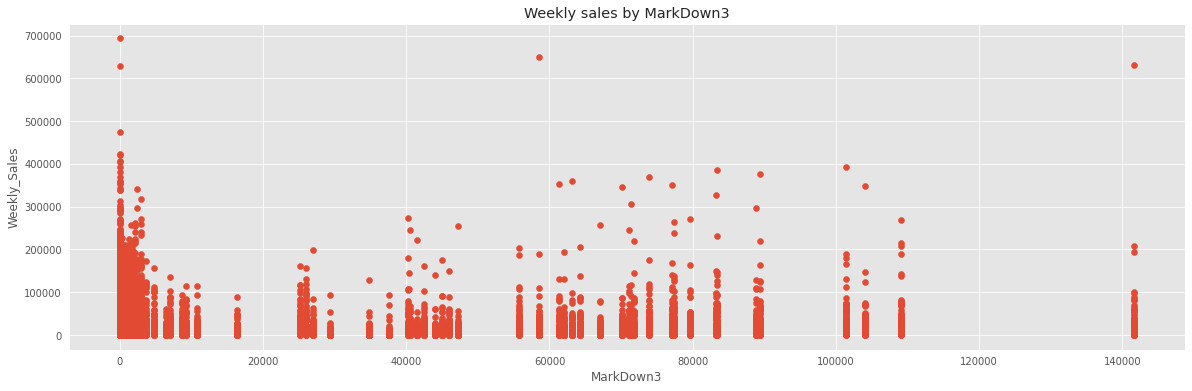

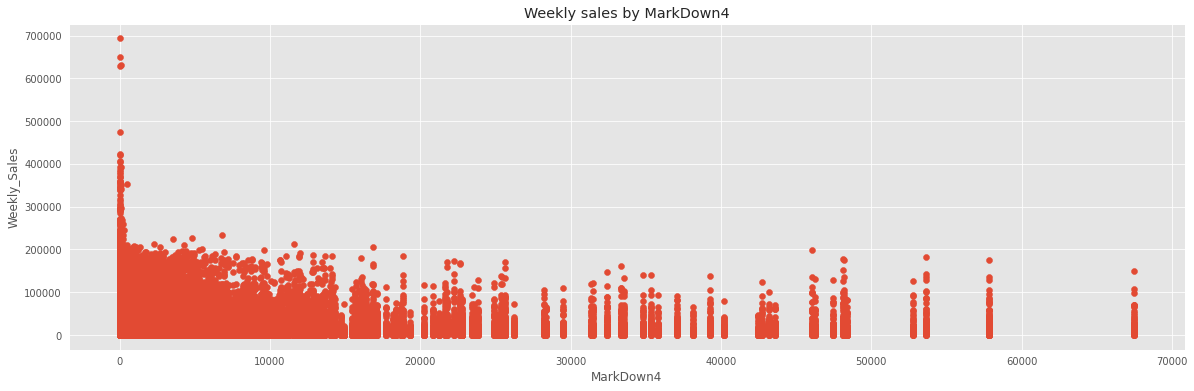

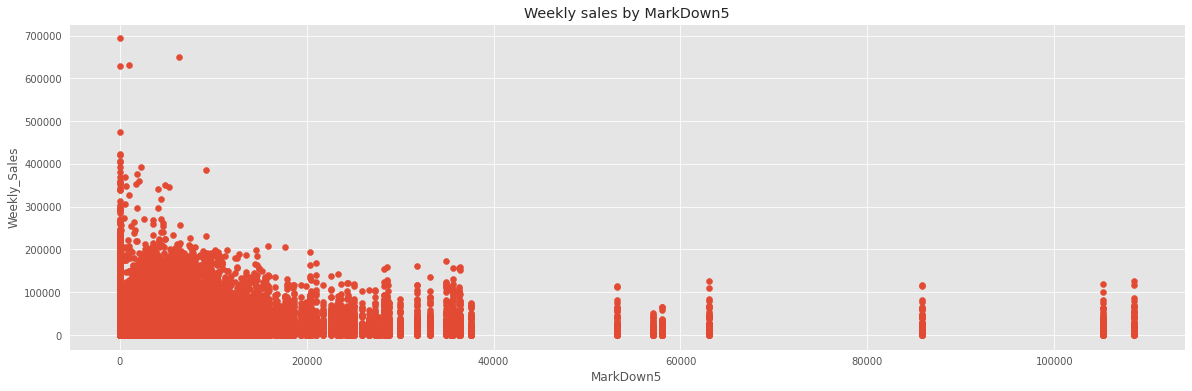

In [67]:
scatter(data, 'MarkDown1')
scatter(data, 'MarkDown2')
scatter(data, 'MarkDown3')
scatter(data, 'MarkDown4')
scatter(data, 'MarkDown5')

  - Observation: Most of the Markdowns have been given for Weekly sales of less than 200000

## 21.Fuel, Temparature and CPI effects

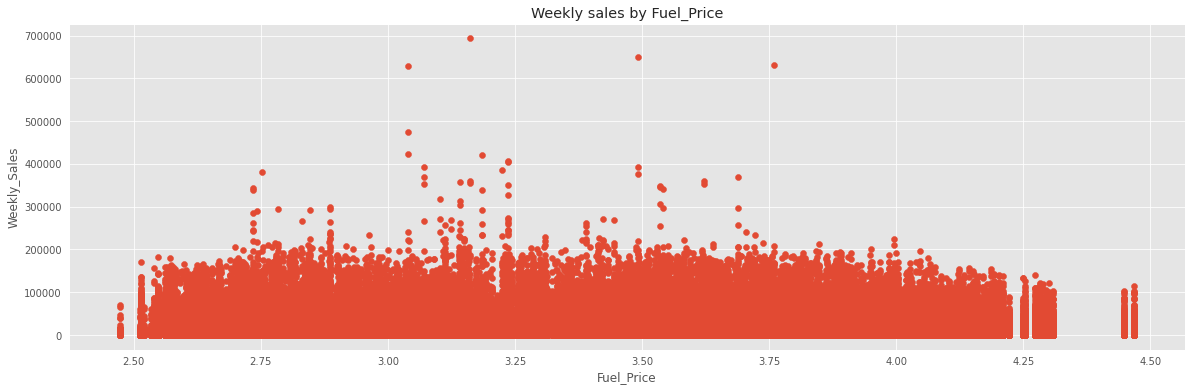

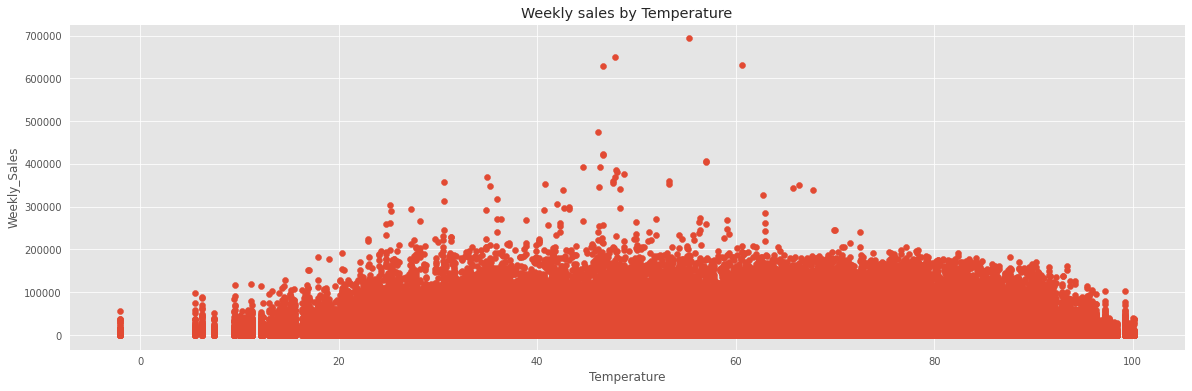

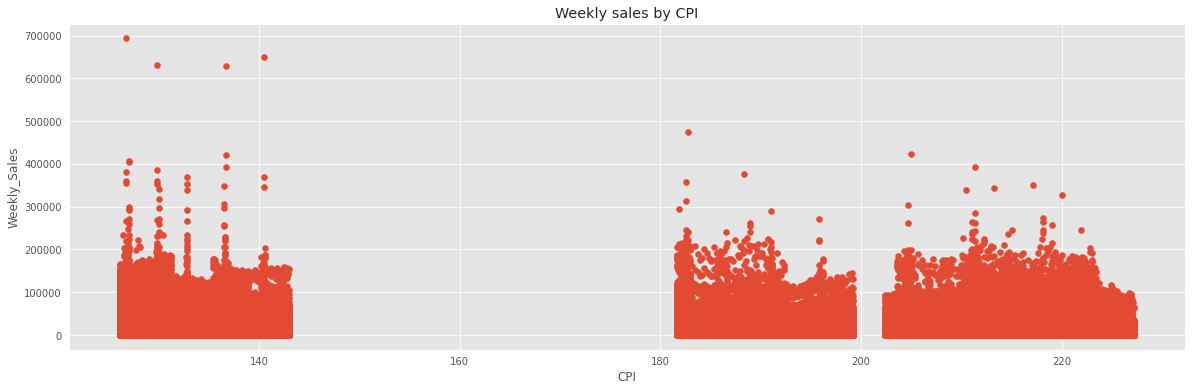

In [68]:
scatter(data, 'Fuel_Price') # Fuel
scatter(data, 'Temperature') #Temparature
scatter(data, 'CPI') #CPI

- Observations:
  1. Most of the Fuel price value lies in range of 2.5 to 4 for weekly sales of less than 200000.
  2. Sales of less than 200000 happened for average temparature range of 30 to 80.
  3. No weekly sales for CPI range of 145 to 180. CPI range (200 - 230) is more when the weekly sales is less than 200000.
  

## Compute Correlation Matrix

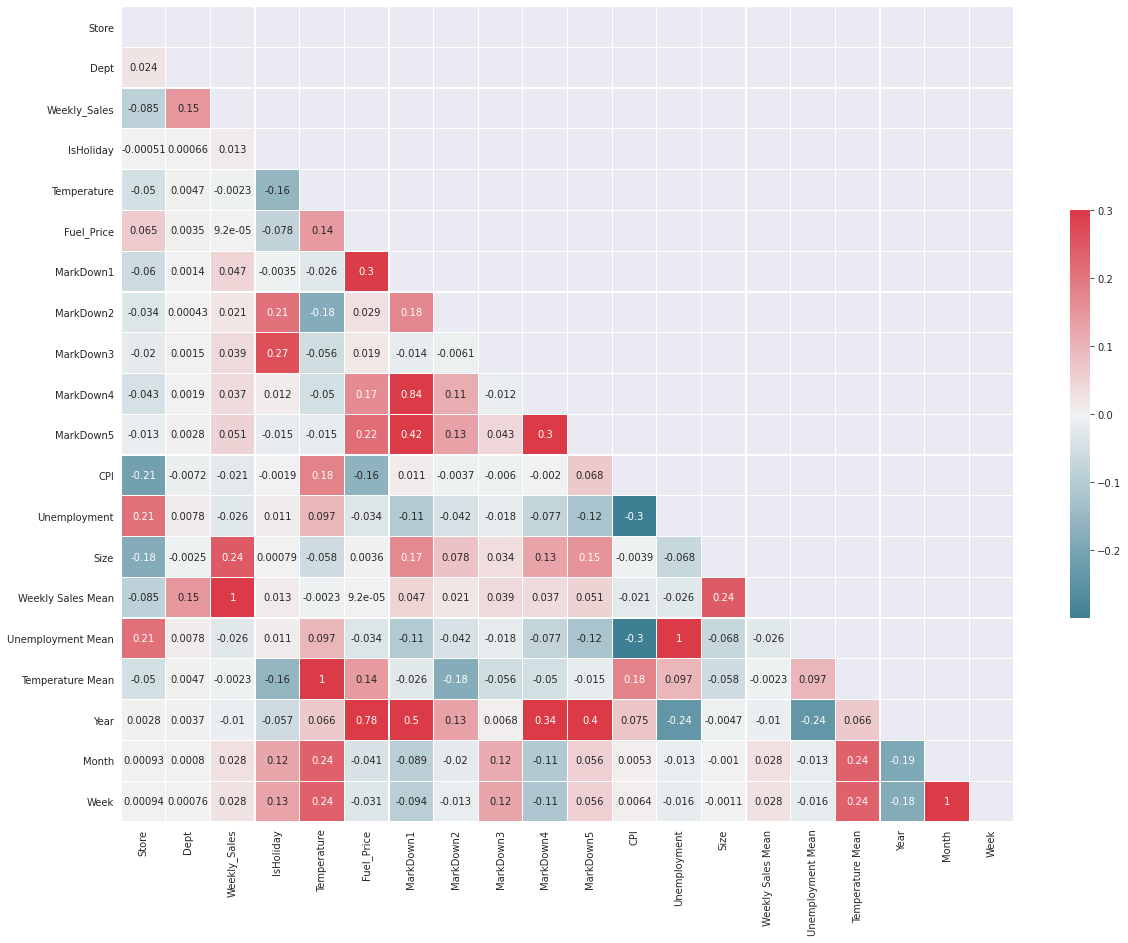

In [69]:
sns.set_style('dark')
corr = data.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

f,ax = plt.subplots(figsize=(20,15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

fig = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            linewidths=.2, cbar_kws={"shrink": .5})

## Logical deductions
 - If the Fuel Price in the area is less then more customers would travel to the store for shopping purpose, however that has a very less correlation.
 - If there is an inflation, Cost of goods will rise which causes CPI to increase. This will cause a reduction in sales which is obvious. But again, CPI doesn't have much correlation.
 - For a lesser store numbers, the weekly sales are higher. Unemployment, Temperature is less, Sales are higher. (Not much correlation)

# Time Series Models

## 1.ARIMA

ARIMA stands for Autoregressive Integrated Moving Average model. Univariate (single vector) ARIMA is a forecasting technique that projects the future values of a series based entirely on its own inertia. Below steps  will compute forecasting values of the input univariate data using ARIMA.
   - Load the data.
   - Visualize the available univariate data in timely fashion.
   - Look at the seasonal decomposition parameter to check for seasonality, trend etc. available or not.
   - Perform a test of stationarity using one of the time-series stationarity methods.
    - If the time series is non-stationary, make it stationary. 
    - If the time series is staionary then no need to make it stationary.
   - Split the univariate data in train and test.
   - The most important step is to find the appropriate values of triplet p,d,q, where p is number of Auto Regressors, d is Integration or difference and q is number of Moving Average by plotting ACF and PACF graphs.
   - Once got the values of p,d,q, fit ARIMA model on train data.
   - Forecast the test data values and plot the visualization of train, test and predicted test data values on single graph.
   - Calculate Root mean squared error (RMSE) on predicted values.

In [70]:
# It is necessary to have the date columns present in the dataset to be available in the datetime format as in ARIMA model it is required to see the sales values in date-wise fashion.
# Hence converting the string formatted Date into datetime format.
data.Date = pd.to_datetime(data.Date,format='%Y-%m-%d')
data.index = data.Date
data = data.drop('Date', axis=1)

In [71]:
data = data.resample('MS').mean() # Resampling the time series data with month starting first.

In [72]:
# Train-Test splitting of time series data
train_data = data[:int(0.7*(len(data)))]
test_data = data[int(0.7*(len(data))):]

print('Train:', train_data.shape)
print('Test:', test_data.shape)

Train: (23, 20)
Test: (10, 20)


In [73]:
print('Train data:\n')
print(train_data.tail())
print('='*50,'\n')
print('Test data:\n')
print(test_data.head())

Train data:

                Store       Dept  Weekly_Sales  ...    Year  Month       Week
Date                                            ...                          
2011-08-01  22.242006  44.356613  16082.682055  ...  2011.0    8.0  32.504733
2011-09-01  22.207410  44.091774  15013.965477  ...  2011.0    9.0  36.999320
2011-10-01  22.147677  44.216090  15536.033513  ...  2011.0   10.0  41.500763
2011-11-01  22.164828  44.374295  17700.949518  ...  2011.0   11.0  45.508465
2011-12-01  22.178926  44.644548  19211.934999  ...  2011.0   12.0  50.000534

[5 rows x 20 columns]

Test data:

                Store       Dept  Weekly_Sales  ...    Year  Month       Week
Date                                            ...                          
2012-01-01  22.186330  44.217667  14304.774064  ...  2012.0    1.0   2.497417
2012-02-01  22.199413  44.516023  16112.853323  ...  2012.0    2.0   6.498238
2012-03-01  22.239420  44.230915  15626.987004  ...  2012.0    3.0  10.995005
2012-04-01  22.

In [74]:
# ARIMA takes univariate data.
train_data = train_data['Weekly_Sales']
test_data = test_data['Weekly_Sales']

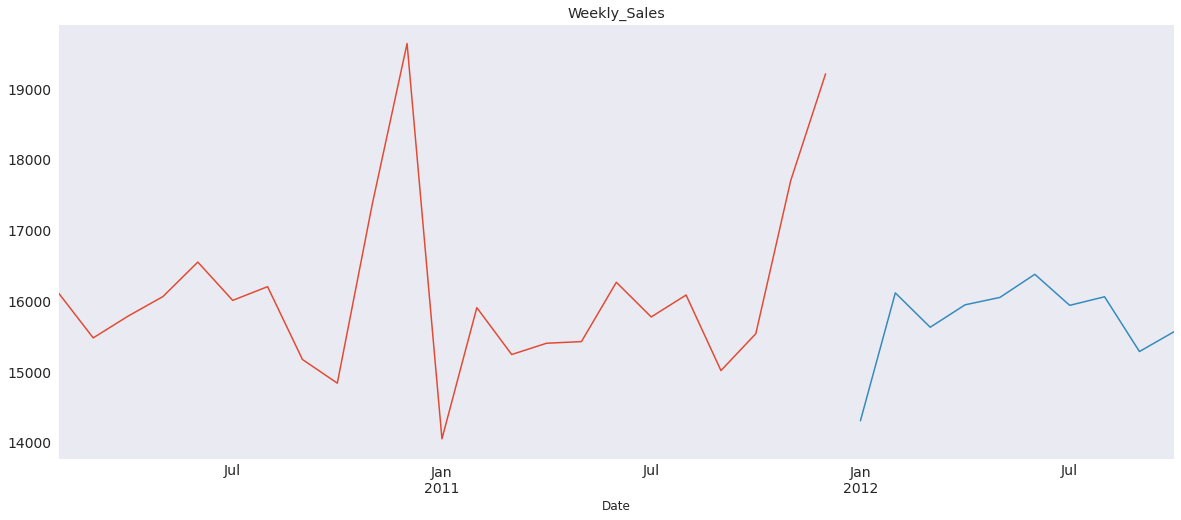

In [75]:
# Plot of Weekly_Sales with respect to years in train and test.
train_data.plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
test_data.plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
plt.show()

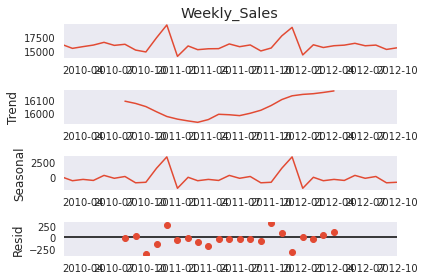

In [76]:
# Decomposition of time series data. It is necessary to see whether the trend, seasonality and residual are present in data or not.
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data['Weekly_Sales'], model='additive')
result.plot()
plt.show()

- Observation:
  - The trend of weekly sales is such that it first decreases then elevates.
  - Given walmart dataset is seasonal dataset as it is repeating the same pattern in the month of Nov-Dec.

**Dickey-Fuller Test for Stationarity**

  - Officially, this is called the ‘augmented Dickey-Fuller test’, but most folks just say ‘Dickey-Fuller’ when talking about it.  This is a test that tests the null hypothesis that a unit root is present in time series data.    To make things a bit more clear, this test is checking for stationarity or non-stationary data.  The test is trying to reject the null hypothesis that a unit root exists and the data is non-stationary. If the null hypothesis is rejected, then the alternate can be considered valid (e.g., the data is stationary).  
  - When you run the test, you’ll get an ADF value and a p-value. The ADF number should be a negative number and the p-value should be beneath a certain threshold value (e.g., 1% or 5%, etc) for a confidence level. Here, we'll use 5% (or 95% confidence level), so if the p-value is greater than 0.05 then we say we fail to reject the null hypothesis because the data has a unit root and is non-stationary.  If the p-value is less than or equal to 0.05, we can say we reject the null hypothesis because the data does not have a unit root and is stationary.

In [77]:
# A check of sationarity of data using Dicky-Fuller test.
from statsmodels.tsa.stattools import adfuller
result = adfuller(data['Weekly_Sales'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -4.17391693510153
p-value: 0.0007291844915316619
Critical Values:
	1%: -3.769732625845229
	5%: -3.005425537190083
	10%: -2.6425009917355373


 - As we can see that our p-value is definitely less than 0.5 and is even less than 0.01 so we can say with pretty good confidence that we can reject the null (unit root, non-stationary data) and can assume our data is stationary. Additionally, our ADF is much less than our 1% confidence value of -3.43, so we have another confirmation that we can reject the null.

**Perform Auto-ARIMA:**
  - We used Auto-ARIMA over ARIMA because in ARIMA model we are required to find appropriate values of number of Auto Regressor (p), number of Moving Average (q), and Integrated (difference, d), which is tedious and time consuming. In Auti-ARIMA we get to see the triplet (p,q,d) values automatically which more importantly best fits the model. Hence we used Auto-ARIMA over ARIMA model.

In [78]:
# Applying auto_arima model on train data.
#model_auto_arima = auto_arima(train_data, trace=True, error_action='ignore', suppress_warnings=True)
model_auto_arima = pmdarima.auto_arima(train_data, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                  max_p=10, max_q=10, max_P=10, max_Q=10, seasonal=True,
                  stepwise=False, suppress_warnings=True, D=1, max_D=10,
                  error_action='ignore',approximation = False)
model_auto_arima.fit(train_data)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=398.029, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=399.604, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=399.313, Time=0.21 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=399.847, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=401.739, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=404.410, Time=0.05 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=400.484, Time=0.14 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=399.857, Time=0.35 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=399.812, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=403.489, Time=0.18 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=405.580, Time=0.09 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=402.539, Time=0.31 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   :

ARIMA(maxiter=50, method='lbfgs', order=(0, 0, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 1),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

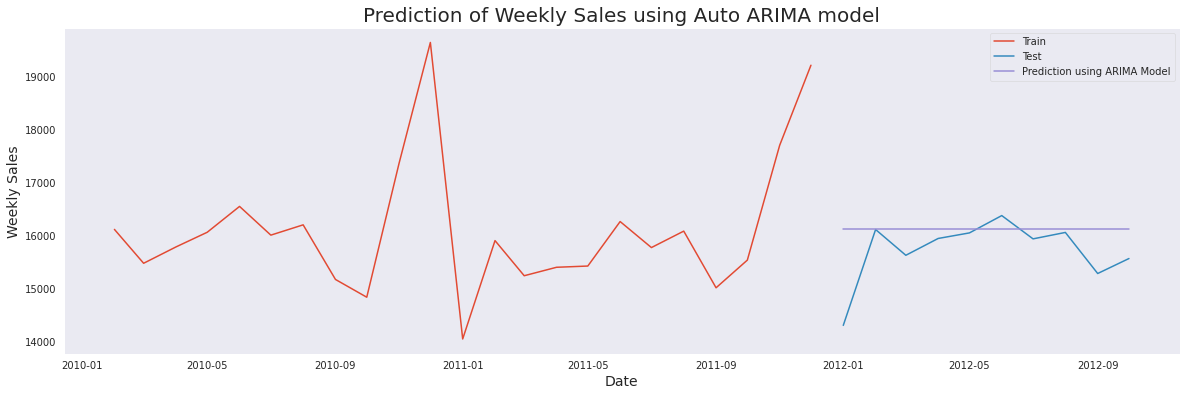

In [79]:
# Predicting the test values using predict function.
forecast = model_auto_arima.predict(n_periods=len(test_data))
forecast = pd.DataFrame(forecast,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using Auto ARIMA model', fontsize=20)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(forecast, label='Prediction using ARIMA Model')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

In [80]:
# Performance metric for ARIMA model -MSE/RMSE
print('Mean Squared Error (MSE) of ARIMA: ', mean_squared_error(test_data, forecast))
print('Root Mean Squared Error (RMSE) of ARIMA: ', math.sqrt(mean_squared_error(test_data, forecast)))
print('Mean Absolute Deviation (MAD) of ARIMA: ', mean_absolute_error(test_data, forecast))

Mean Squared Error (MSE) of ARIMA:  469971.0831842115
Root Mean Squared Error (RMSE) of ARIMA:  685.5443699602612
Mean Absolute Deviation (MAD) of ARIMA:  446.993850052157


In [81]:
# arima_train = train.sort_values(by='Date', ascending=True) # Sorting the data in increasing order of Date and then splitting.
# y = arima_train['Weekly_Sales']
# X = arima_train.drop(['Weekly_Sales'], axis=1)

# def wmae_arima(test, pred): # WMAE for train
#   weights = X['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
#   error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
#   return error

# print('WMAE of ARIMA: ', wmae_arima(X, y))

## 2.Holt Winters Model

Holt-Winters is a time-series model and is a way to model three aspects of the time series: a typical value (average), a slope (trend) over time, and a cyclical repeating pattern (seasonality). Holt-Winters uses exponential smoothing to encode lots of values from the past and use them to predict “typical” values for the present and future. Below steps are required to use Holt-Winters model.
 - Load the data.
 - Visualize the available univariate data in timely fashion.
 - Fit the model using Holt-Winters method on train data.
 - Predict the values using of test data. 
 - Visualize the training data, test data and predicted data on single graph.
 - Calculate Root Mean Squared Error (RMSE) on predicted data..


Train data shape:  (23,)
Test data shape:  (10,)
Train data:

Date
2011-08-01    16082.682055
2011-09-01    15013.965477
2011-10-01    15536.033513
2011-11-01    17700.949518
2011-12-01    19211.934999
Freq: MS, Name: Weekly_Sales, dtype: float64 

Test data:

Date
2012-01-01    14304.774064
2012-02-01    16112.853323
2012-03-01    15626.987004
2012-04-01    15944.188683
2012-05-01    16049.064164
Freq: MS, Name: Weekly_Sales, dtype: float64


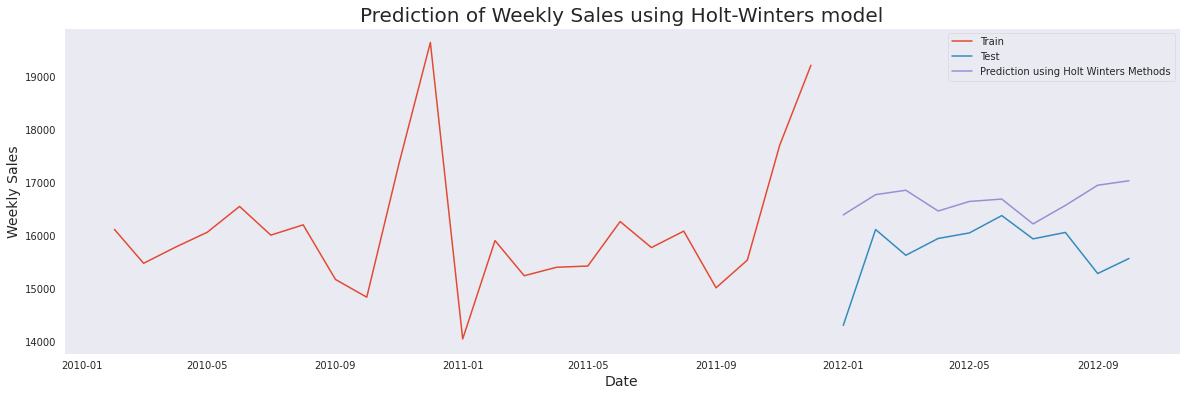

In [83]:
# Fitting the Holt-Winters method for Weekly Sales.
from statsmodels.tsa.api import ExponentialSmoothing
model_holt_winters = ExponentialSmoothing(train_data, seasonal_periods=7, trend='additive', seasonal='additive').fit() #Taking additive trend and seasonality.
pred = model_holt_winters.forecast(len(test_data))# Predict the test data

#Visualize train, test and predicted data.
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using Holt-Winters model', fontsize=20)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred, label='Prediction using Holt Winters Methods')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

In [84]:
# Performance metric for Holt-Winters model -MSE/RMSE
print('Mean Squared Error (MSE) of Holt-Winters: ', mean_squared_error(test_data, pred))
print('Root Mean Squared Error (RMSE) of Holt-Winters: ', math.sqrt(mean_squared_error(test_data, pred)))
print('Mean Absolute Deviation (MAD) of Holt-Winters: ', mean_absolute_error(test_data, pred))

Mean Squared Error (MSE) of Holt-Winters:  1226585.5984139615
Root Mean Squared Error (RMSE) of Holt-Winters:  1107.5132497690317
Mean Absolute Deviation (MAD) of Holt-Winters:  931.6608419986494


# Data Pre-processing

## Standard 

In [85]:
train_ = train

In [86]:
#Joining the train data with store and features data using inner join.
train = train.merge(features, on=['Store', 'Date'], how='inner').merge(stores, on=['Store'], how='inner')
print(train.shape)

(421570, 17)


In [87]:

# Make one IsHoliday column instead of two.
train = train.drop(['IsHoliday_y'], axis=1)
train = train.rename(columns={'IsHoliday_x':'IsHoliday'})
print('Train columns:\n', train.columns)

Train columns:
 Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size'],
      dtype='object')


### Extract Date

In [88]:
# Converting Date to datetime
train['Date'] = pd.to_datetime(train['Date'])

# Extract date features
train['Date_dayofweek'] = train['Date'].dt.dayofweek
train['Date_month'] = train['Date'].dt.month 
train['Date_year'] = train['Date'].dt.year
train['Date_day'] = train['Date'].dt.day 

### Numeric Encoding

In [89]:
train_data = [train]

# Converting Categorical Variable 'Type' into Numerical Variables.
type_mapping = {"A": 1, "B": 2, "C": 3}
for dataset in train_data:
    dataset['Type'] = dataset['Type'].map(type_mapping)

# Converting Categorical Variable 'IsHoliday' into Numerical Variables.
type_mapping = {False: 0, True: 1}
for dataset in train_data:
    dataset['IsHoliday'] = dataset['IsHoliday'].map(type_mapping)

### New holidays -  Super Bowl, Labor Day, Thanksgiving and Christmas

In [90]:
# Kaggle has provided some dates to be allocated to special holidays. We have taken the special holidays into account and marked them as holidays.
train['Super_Bowl'] = np.where((train['Date'] == datetime(2010,2,10)) | (train['Date'] == datetime(2011,2,11)) | 
                               (train['Date'] == datetime(2012,2,10)) | (train['Date'] == datetime(2013,2,8)), 1, 0)
train['Labor_day'] = np.where((train['Date'] == datetime(2010,9,10)) | (train['Date'] == datetime(2011,9,9)) | 
                              (train['Date'] == datetime(2012,9,7)) | (train['Date'] == datetime(2013,9,6)), 1, 0)
train['Thanksgiving'] = np.where((train['Date']==datetime(2010, 11, 26)) | (train['Date']==datetime(2011, 11, 25)) | 
                                 (train['Date']==datetime(2012, 11, 23)) | (train['Date']==datetime(2013, 11, 29)),1,0)
train['Christmas'] = np.where((train['Date']==datetime(2010, 12, 31)) | (train['Date']==datetime(2011, 12, 30)) | 
                              (train['Date']==datetime(2012, 12, 28)) | (train['Date']==datetime(2013, 12, 27)),1,0)

In [91]:
print('Train holidays:\n')
print ('Christmas:\n', train.Christmas.value_counts(),'\n')
print ('Super Bowl:\n', train.Super_Bowl.value_counts(),'\n')
print ('Thanksgiving:\n', train.Thanksgiving.value_counts(),'\n')
print ('Labor Day:\n', train.Labor_day.value_counts(),'\n')

Train holidays:

Christmas:
 0    415624
1      5946
Name: Christmas, dtype: int64 

Super Bowl:
 0    415631
1      5939
Name: Super_Bowl, dtype: int64 

Thanksgiving:
 0    415611
1      5959
Name: Thanksgiving, dtype: int64 

Labor Day:
 0    412709
1      8861
Name: Labor_day, dtype: int64 



In [92]:
# Since we have Imputed IsHoliday according to Extra holidays..These extra holiday variable has redundant.
# Droping the Extra holiday variables because its redundant.
dp = ['Super_Bowl','Labor_day','Thanksgiving','Christmas']
train.drop(dp, axis=1, inplace=True)

In [93]:
train = train.fillna(0)
#Remove negative values as sales cannot be negative.
train = train[train['Weekly_Sales'] >= 0]
train.shape

(420285, 20)

In [94]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420285 entries, 0 to 421569
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Store           420285 non-null  int64         
 1   Dept            420285 non-null  int64         
 2   Date            420285 non-null  datetime64[ns]
 3   Weekly_Sales    420285 non-null  float64       
 4   IsHoliday       420285 non-null  int64         
 5   Temperature     420285 non-null  float64       
 6   Fuel_Price      420285 non-null  float64       
 7   MarkDown1       420285 non-null  float64       
 8   MarkDown2       420285 non-null  float64       
 9   MarkDown3       420285 non-null  float64       
 10  MarkDown4       420285 non-null  float64       
 11  MarkDown5       420285 non-null  float64       
 12  CPI             420285 non-null  float64       
 13  Unemployment    420285 non-null  float64       
 14  Type            420285 non-null  int

## Remove unnecessary columns

In [95]:
# Not so important features.
# features_drop=['Unemployment','CPI','MarkDown5']
features_drop = ['Date_year','CPI','MarkDown1']
train_imp = train.drop(features_drop, axis=1)

print('Final train shape:', train_imp.shape)
train_imp.head(2)

Final train shape: (420285, 17)


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Unemployment,Type,Size,Date_dayofweek,Date_month,Date_day
0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.0,0.0,0.0,0.0,8.106,1,151315,4,2,5
1,1,2,2010-02-05,50605.27,0,42.31,2.572,0.0,0.0,0.0,0.0,8.106,1,151315,4,2,5


## Train-Test splitting

In [96]:
train_imp = train_imp.sort_values(by='Date', ascending=True) # Sorting the data in increasing order of Date and then splitting.
y = train_imp['Weekly_Sales']
X = train_imp.drop(['Weekly_Sales'], axis=1) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # Train:Test = 70:30 splitting.
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3) #Train:CV = 70:30 splitting.

# Remove Date column as it does not allow the models to fit on the data. 
X_train = X_train.drop(['Date'], axis=1)
X_cv = X_cv.drop(['Date'], axis=1)
X_test = X_test.drop(['Date'], axis=1)

# Final shapes.
print('Train:', X_train.shape, y_train.shape)
print('CV:', X_cv.shape, y_cv.shape)
print('Test', X_test.shape, y_test.shape)

Train: (205939, 15) (205939,)
CV: (88260, 15) (88260,)
Test (126086, 15) (126086,)


In [97]:
"""Define Performance metric - Weighted Mean Absolute Error (WMAE)"""

def wmae_train(test, pred): # WMAE for train
  weights = X_train['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
  error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
  return error  

def wmae_cv(test, pred): # WMAE for CV
  weights = X_cv['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
  error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
  return error

def wmae_test(test, pred): # WMAE for test
  weights = X_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
  error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
  return error

# Apply Regreesion Models

Here we will use below regression models for Weekly Sales Prediction.
  - Linear Reagression
  - K Nearest Neighbors Regression
  - Ridge Regression
  - Lasso Regression
  - Decision Tree Regression
  - Random Forest Regression
  - ExtraTrees Regression
  - XGBoost Regression

In every model below steps will be performed.
  - Define the parameters that each library takes.
  - Fit the model on training data.
  - Hyperparameter-tune the parameters using GridSearch/RandomSearch technique.
  - Retrain the model on tuned paramteres.
  - Predict the test values.
  - Get the accuracy using score function.


## 1.Linear Regression

In [98]:
# # Define list of empty train error and cv error.
# error_cv_lr = []
# error_train_lr = []
# fit_intercept = [True,False]
# normalize = [True,False]
# lr_hyperparams = []

# """Calculating train and CV errors for Fit Intercept and Normalize parameters."""

# for i in fit_intercept:
#     for j in normalize:
#         lr = LinearRegression(fit_intercept=i, normalize=j) # Apply Linear Regression.
#         lr.fit(X_train, y_train) # Fit the model.
#         y_pred_cv_lr = lr.predict(X_cv) # Predict CV data.
#         y_pred_train_lr = lr.predict(X_train) # Predict Train data.
#         error_cv_lr.append(wmae_cv(y_cv, y_pred_cv_lr)) # Get CV error.
#         error_train_lr.append(wmae_train(y_train, y_pred_train_lr)) # Get Train error.
#         lr_hyperparams.append({'Fit Intercept':i, 'Normalize':j}) # Hyperparameters.

In [99]:
# """Making dataframe containing values of hyper parameters with train and cv errors for the purpose of creating heatmaps."""

# lr_dataframe = pd.DataFrame(lr_hyperparams)
# lr_dataframe['Train Error'] = error_train_lr
# lr_dataframe['CV Error'] = error_cv_lr
# lr_dataframe.sort_values(by=['CV Error'], ascending=True)
# lr_dataframe

In [100]:
# """Creating heatmaps for Train loss and CV loss."""

# sns.set(font_scale=1.3)
# train_lr = pd.pivot_table(lr_dataframe,'Train Error','Fit Intercept','Normalize') # Train Pivot table
# cv_lr = pd.pivot_table(lr_dataframe, 'CV Error','Fit Intercept','Normalize') # CV Pivot table.
# fig, ax = plt.subplots(1,2, figsize=(20,6))
# ax_train = sns.heatmap(train_lr, annot=True, fmt='4g', ax=ax[0]) # Train heatmap.
# ax_cv = sns.heatmap(cv_lr, annot=True, fmt='4g', ax=ax[1]) # CV heatmap.

# bottom_train, top_train = ax_train.get_ylim()
# ax_train.set_ylim(bottom_train + 0.5, top_train - 0.5)

# bottom_cv, top_cv = ax_cv.get_ylim()
# ax_cv.set_ylim(bottom_cv + 0.5, top_cv - 0.5)

# ax[0].set_title('Training set')
# ax[1].set_title('CV set')
# plt.show()

  - Observation: Taking fit_interceot=True and normalize=True as error values are same everywhere.
  

In [101]:
# """Calculate Prediction and WMAE score."""

# model_linear_reg = LinearRegression(fit_intercept=True,normalize=True).fit(X_train,y_train) # Fit the model.
# y_pred = model_linear_reg.predict(X_test) # Predict test data.
# print('Weighted Mean Absolute Error (WMAE) for Linear Regression:', wmae_test(y_test, y_pred)) # Calculate WMAE score.

## 2.KNN Regression

In [102]:
# # Define empty train and CV error lists and list of hyper parameter values. 
# error_cv = []
# error_train = []

# for i in range(3,22,2): # Loop over number of nearest neighbors (K) values [3,5,7,9,11,13,15,17,19,21].
#     knn = KNeighborsRegressor(n_neighbors=i) # Apply KNN Regressor.
#     knn.fit(X_train, y_train) # Fit the model.
#     y_pred_cv= knn.predict(X_cv) # Predict CV data.
#     y_pred_train= knn.predict(X_train) # Predict Train data.
#     error_cv.append(wmae_cv(y_cv, y_pred_cv)) # Get CV error.
#     error_train.append(wmae_train(y_train, y_pred_train)) # Get Train error.

In [103]:
# """Plot Train error and CV error against number of nearest neighbors (K) values to select best hyper parameter."""

# plt.figure(figsize=(15, 6))
# plt.plot(range(3,22,2), error_cv, color='red', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10, label='CV Error')
# plt.plot(range(3,22,2), error_train, color='green', linestyle='dashed', marker='o',markerfacecolor='green', markersize=10, label='Train Error')
# plt.legend(loc='best')
# plt.title('Error Rate Vs K Value', fontsize=14)
# plt.xlabel('K Value',fontsize=12)
# plt.ylabel('Weighted Mean Absolute Error (WMAE)', fontsize=12)
# plt.show()

 - Observation: Best value of hyperparameter K is 11 as both training and CV error scores are low at K=11.

In [104]:
# """Calculate Prediction and WMAE score."""

# model_knn = KNeighborsRegressor(n_neighbors=11).fit(X_train, y_train) # Fit the model with best K value.
# y_pred_test = model_knn.predict(X_test) # Predict test data.
# print('Weighted Mean Absolute Error (WMAE) for KNN Regression:', wmae_test(y_test, y_pred_test)) # Calculate WMAE score.

## 3.Decision Tree Regression

In [105]:
# # Define the list of errors and list of hyper parameters.
# error_cv_dt = []
# error_train_dt = []
# max_depth = [1,5,10,15,20,25,30,35]
# min_samples_leaf = [1,2,3,4,5,6,7,8]
# dt_hyperparams = []

# """Calculating train and CV errors for maximum depth and minimum samples leaf parameters."""

# for i in max_depth: # Loop over max_depth.
#     for j in min_samples_leaf: # Loop over min_samples_leaf.
#         dt = DecisionTreeRegressor(max_depth=i, min_samples_leaf=j) # Apply Decision Tree Regressor.
#         dt.fit(X_train, y_train) # Fit the model.
#         y_pred_cv_dt = dt.predict(X_cv) # Predict CV data.
#         y_pred_train_dt = dt.predict(X_train) # Predict Train data.
#         error_cv_dt.append(wmae_cv(y_cv, y_pred_cv_dt)) # Calculate CV error.
#         error_train_dt.append(wmae_train(y_train, y_pred_train_dt)) # Calculate Train error.
#         dt_hyperparams.append({'depth':i, 'leaf':j}) # Get the list of hyper parameters.

In [106]:
# """Making dataframe containing values of hyper parameters with train and cv errors for the purpose of creating heatmaps."""

# dt_dataframe = pd.DataFrame(dt_hyperparams)
# dt_dataframe['train error'] = error_train_dt
# dt_dataframe['cv error'] = error_cv_dt
# dt_dataframe.sort_values(by=['cv error'], ascending=True)
# dt_dataframe.head()

In [107]:
# """Creating heatmaps for Train loss and CV loss."""

# sns.set(font_scale=1.1,)
# train_dt = pd.pivot_table(dt_dataframe ,'train error','depth','leaf') # Pivot table for train.
# cv_dt = pd.pivot_table(dt_dataframe , 'cv error','depth','leaf') # Pivot table for CV.
# fig, ax = plt.subplots(1,2, figsize=(20,6))
# sns.heatmap(train_dt, annot=True, fmt='2g', ax=ax[0]) # Train heatmap.
# sns.heatmap(cv_dt, annot=True, fmt='4g', ax=ax[1]) # CV heatmap.
# ax[0].set_title('Training set')
# ax[1].set_title('CV set')
# plt.show()

  - Observation: The Training loss and CV loss are least for maximum depth of 25 and minimum samples leaf of 5.

In [108]:
# """Calculate Prediction and WMAE score."""

# model_dt = DecisionTreeRegressor(max_depth=25, min_samples_leaf=5).fit(X_train, y_train) # Fit the model with best hyper parameter values.
# y_pred = model_dt.predict(X_test) # Predict the test data.
# print('Weighted Mean Absolute Error (WMAE) for Decision Tree Regression:', wmae_test(y_test, y_pred)) # Get WMAE score.

### Random Forest Regression

In [109]:
# # Define the list of errors and list of hyper parameters.
# error_cv_rf = []
# error_train_rf = []
# max_depth = [1,5,10,15,20,25,30,35]
# n_estimators = [10,20,30,40,50,60,70,80]
# rf_hyperparams = []

# """Calculating train and CV errors for maximum depth and number of estimators parameters."""

# for i in max_depth: # Loop over max_depth.
#     for j in n_estimators: # Loop over n_estimators. 
#         rf = RandomForestRegressor(max_depth=i, n_estimators=j) # Apply Random Forest Regressor.
#         rf.fit(X_train, y_train) # Fit the model.
#         y_pred_cv_rf = rf.predict(X_cv) # Predict CV data.
#         y_pred_train_rf = rf.predict(X_train) # Predict Train data.
#         error_cv_rf.append(wmae_cv(y_cv, y_pred_cv_rf)) # Get CV error.
#         error_train_rf.append(wmae_train(y_train, y_pred_train_rf)) # Get Train error.
#         rf_hyperparams.append({'Maximum Depth':i, 'No. of Estimators':j}) # Get list of hyper parameter values.

In [110]:
# """Making dataframe containing values of hyper parameters with train and cv errors for the purpose of creating heatmaps."""

# rf_dataframe = pd.DataFrame(rf_hyperparams)
# rf_dataframe['Train Error']=error_train_rf
# rf_dataframe['CV Error']=error_cv_rf
# rf_dataframe.sort_values(by=['CV Error'], ascending=True)
# rf_dataframe.head()

In [111]:
# """Creating heatmaps for Train loss and CV loss."""

# sns.set(font_scale=1.0)
# train_rf = pd.pivot_table(rf_dataframe,'Train Error','Maximum Depth','No. of Estimators') # Pivot table of Train data.
# cv_rf = pd.pivot_table(rf_dataframe, 'CV Error','Maximum Depth','No. of Estimators') # Pivot table of CV data.
# fig, ax = plt.subplots(1,2, figsize=(20,6))
# ax_train = sns.heatmap(train_rf, annot=True, fmt='2g', ax=ax[0], linewidths=0.01)
# ax_cv = sns.heatmap(cv_rf, annot=True, fmt='4g', ax=ax[1], linewidths=0.01)

# bottom_train, top_train = ax_train.get_ylim()
# ax_train.set_ylim(bottom_train + 0.5, top_train - 0.5)

# bottom_cv, top_cv = ax_cv.get_ylim()
# ax_cv.set_ylim(bottom_cv + 0.5, top_cv - 0.5)

# ax[0].set_title('Training set')
# ax[1].set_title('CV set')
# plt.show()

  - Observation: The training loss and CV loss are least for Maximum Depth of 35 and Number of Estimators of 80 .

In [112]:
# """Calculate Prediction and  WMAE score."""

# model_rf = RandomForestRegressor(max_depth= 35, n_estimators=80).fit(X_train, y_train) # Fit the model with best hyper parameter values.
# y_pred = model_rf.predict(X_test) # Predict the test data.
# print('Weighted Mean Absolute Error (WMAE) for Random Forest Regression:', wmae_test(y_test, y_pred)) # Get WMAE score.

# Result

In [113]:
models = pd.DataFrame({
    'Model Name': ['Linear Regression','KNN Regression','Decision Tree Regression'],
    
    'WMAE Score': ['14904.66', '11887.99', '2134.17']
    })

Index = pd.Series([1, 2, 3])
models.set_index(Index, inplace=True)
models

,Model Name,WMAE Score
1,Linear Regression,14904.66
2,KNN Regression,11887.99
3,Decision Tree Regression,2134.17


Test data Preprocess 

In [114]:
#Reading kaggle provided test file for which the prediction is needed.
test_kaggle = pd.read_csv(data_dir + 'test.csv')
test_kaggle.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [115]:
test_kaggle = test_kaggle.merge(features, on=['Store', 'Date'], how='inner').merge(stores, on=['Store'], how='inner') # Joining test data with store and features.
print(test_kaggle.shape)

# Making IsHoliday as one column.
test_kaggle = test_kaggle.drop(['IsHoliday_y'], axis=1)
test_kaggle = test_kaggle.rename(columns={'IsHoliday_x':'IsHoliday'})
print('Test_Kaggle columns:\n', test_kaggle.columns)

# Converting Date to datetime
test_kaggle['Date'] = pd.to_datetime(test_kaggle['Date'])

# Extract date features
test_kaggle['Date_dayofweek'] = test_kaggle['Date'].dt.dayofweek
test_kaggle['Date_month'] = test_kaggle['Date'].dt.month 
test_kaggle['Date_year'] = test_kaggle['Date'].dt.year
test_kaggle['Date_day'] = test_kaggle['Date'].dt.day 


(115064, 16)
Test_Kaggle columns:
 Index(['Store', 'Dept', 'Date', 'IsHoliday', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'Type', 'Size'],
      dtype='object')


In [116]:
test_kaggle_data = [test_kaggle]

# Converting Categorical Variable 'Type' into Numerical Variables.
type_mapping = {"A": 1, "B": 2, "C": 3}
for dataset in test_kaggle_data:
    dataset['Type'] = dataset['Type'].map(type_mapping)

# Converting Categorical Variable 'IsHoliday' into Numerical Variables.
type_mapping = {False: 0, True: 1}
for dataset in test_kaggle_data:
    dataset['IsHoliday'] = dataset['IsHoliday'].map(type_mapping)
#test = test.drop(['Date'], axis=1)


In [117]:
# Special holidays.
test_kaggle['Super_Bowl'] = np.where((test_kaggle['Date'] == datetime(2010,2,10)) | (test_kaggle['Date'] == datetime(2011,2,11)) | 
                               (test_kaggle['Date'] == datetime(2012,2,10)) | (test_kaggle['Date'] == datetime(2013,2,8)), 1, 0)
test_kaggle['Labor_day'] = np.where((test_kaggle['Date'] == datetime(2010,9,10)) | (test_kaggle['Date'] == datetime(2011,9,9)) | 
                              (test_kaggle['Date'] == datetime(2012,9,7)) | (test_kaggle['Date'] == datetime(2013,9,6)), 1, 0)
test_kaggle['Thanksgiving'] = np.where((test_kaggle['Date']==datetime(2010, 11, 26)) | (test_kaggle['Date']==datetime(2011, 11, 25)) | 
                                 (test_kaggle['Date']==datetime(2012, 11, 23)) | (test_kaggle['Date']==datetime(2013, 11, 29)),1,0)
test_kaggle['Christmas'] = np.where((test_kaggle['Date']==datetime(2010, 12, 31)) | (test_kaggle['Date']==datetime(2011, 12, 30)) | 
                              (test_kaggle['Date']==datetime(2012, 12, 28)) | (test_kaggle['Date']==datetime(2013, 12, 27)),1,0)

In [118]:
# Since we have Imputed IsHoliday according to Extra holidays..These extra holiday variable has redundant.
# Droping the Extra holiday variables because its redundant.
dp = ['Super_Bowl','Labor_day','Thanksgiving','Christmas']
test_kaggle.drop(dp, axis=1, inplace=True)

In [119]:
test_kaggle = test_kaggle.fillna(0) # Filling null values with 0.

In [120]:
test_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Store           115064 non-null  int64         
 1   Dept            115064 non-null  int64         
 2   Date            115064 non-null  datetime64[ns]
 3   IsHoliday       115064 non-null  int64         
 4   Temperature     115064 non-null  float64       
 5   Fuel_Price      115064 non-null  float64       
 6   MarkDown1       115064 non-null  float64       
 7   MarkDown2       115064 non-null  float64       
 8   MarkDown3       115064 non-null  float64       
 9   MarkDown4       115064 non-null  float64       
 10  MarkDown5       115064 non-null  float64       
 11  CPI             115064 non-null  float64       
 12  Unemployment    115064 non-null  float64       
 13  Type            115064 non-null  int64         
 14  Size            115064 non-null  int

In [121]:
# Removing unimportant features.
# features_drop = ['Unemployment','CPI','MarkDown5']
features_drop = ['Date_year','CPI','MarkDown1']
test_kaggle = test_kaggle.drop(features_drop, axis=1)

In [122]:
#Excluding Date as it throws error while making prediction.
test_kaggle = test_kaggle.loc[:, test_kaggle.columns != 'Date']

In [123]:
print('Final test_kaggle shape:', test_kaggle.shape)
test_kaggle.head(2)

Final test_kaggle shape: (115064, 15)


,Store,Dept,IsHoliday,Temperature,Fuel_Price,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Unemployment,Type,Size,Date_dayofweek,Date_month,Date_day
0,1,1,0,55.32,3.386,5147.7,50.82,3639.9,2737.42,6.573,1,151315,4,11,2
1,1,2,0,55.32,3.386,5147.7,50.82,3639.9,2737.42,6.573,1,151315,4,11,2


In [124]:
# # Applying Random Forest to kaggle provided test file with the best hyper parameter values we got during training phase in Random Forest.
# y_ = train['Weekly_Sales']
# X_ = train.drop(['Weekly_Sales', 'Date'], axis=1) 
# X_ = X_.drop(features_drop, axis=1)

# model_rf = RandomForestRegressor(max_depth= 35, n_estimators=80).fit(X_, y_) # Fit the model with original train data.
# y_pred = model_rf.predict(test_kaggle) # Predict the final test data that Kaggle has provided.

In [125]:
y_ = train['Weekly_Sales']
X_ = train.drop(['Weekly_Sales', 'Date'], axis=1)
X_ = X_.drop(features_drop, axis=1)

model_dt = DecisionTreeRegressor(max_depth=25, min_samples_leaf=5).fit(X_, y_) 
y_pred = model_dt.predict(test_kaggle)  

In [129]:
test_kaggle

,Store,Dept,IsHoliday,Temperature,Fuel_Price,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Unemployment,Type,Size,Date_dayofweek,Date_month,Date_day
0,1,1,0,55.32,3.386,5147.70,50.82,3639.90,2737.42,6.573,1,151315,4,11,2
1,1,2,0,55.32,3.386,5147.70,50.82,3639.90,2737.42,6.573,1,151315,4,11,2
2,1,3,0,55.32,3.386,5147.70,50.82,3639.90,2737.42,6.573,1,151315,4,11,2
3,1,4,0,55.32,3.386,5147.70,50.82,3639.90,2737.42,6.573,1,151315,4,11,2
4,1,5,0,55.32,3.386,5147.70,50.82,3639.90,2737.42,6.573,1,151315,4,11,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115059,45,93,0,76.06,3.804,851.73,2.06,10.88,1864.57,0.000,2,118221,4,7,26
115060,45,94,0,76.06,3.804,851.73,2.06,10.88,1864.57,0.000,2,118221,4,7,26
115061,45,95,0,76.06,3.804,851.73,2.06,10.88,1864.57,0.000,2,118221,4,7,26
115062,45,97,0,76.06,3.804,851.73,2.06,10.88,1864.57,0.000,2,118221,4,7,26


In [130]:
y_pred

array([31749.825     , 48663.49714286, 10908.204     , ...,
       57337.23428571,  7682.5525    ,  1403.85833333])

**Submission File**

In [127]:
test_kaggle_ = pd.read_csv(data_dir+'test.csv')
print(test_kaggle_.shape)
test_kaggle_.head()

(115064, 4)


,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [128]:
submission = pd.DataFrame({
        "Id": test_kaggle_.Store.astype(str)+'_'+test_kaggle_.Dept.astype(str)+'_'+test_kaggle_.Date.astype(str),
        "Weekly_Sales": y_pred 
    })

submission.to_csv('WeeklySalesPrediction_DT.csv', index=False) 

In [131]:
submission

,Id,Weekly_Sales
0,1_1_2012-11-02,31749.825000
1,1_1_2012-11-09,48663.497143
2,1_1_2012-11-16,10908.204000
3,1_1_2012-11-23,21932.768333
4,1_1_2012-11-30,23947.246000
...,...,...
115059,45_98_2013-06-28,4569.501429
115060,45_98_2013-07-05,6679.612000
115061,45_98_2013-07-12,57337.234286
115062,45_98_2013-07-19,7682.552500


In [139]:
test_kaggle[115061:]

,Store,Dept,IsHoliday,Temperature,Fuel_Price,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Unemployment,Type,Size,Date_dayofweek,Date_month,Date_day
115061,45,95,0,76.06,3.804,851.73,2.06,10.88,1864.57,0.0,2,118221,4,7,26
115062,45,97,0,76.06,3.804,851.73,2.06,10.88,1864.57,0.0,2,118221,4,7,26
115063,45,98,0,76.06,3.804,851.73,2.06,10.88,1864.57,0.0,2,118221,4,7,26


In [140]:
submission[115061:]

,Id,Weekly_Sales
115061,45_98_2013-07-12,57337.234286
115062,45_98_2013-07-19,7682.552500
115063,45_98_2013-07-26,1403.858333
